考虑守恒律方程：  
$$ u_t + f(u)_x = 0 $$
其中$f(u)$是光滑函数，$u$是标量函数。  

常用的守恒格式：  
$$ u_j^{n+1} = u_j^n - \lambda(f_{j+\frac{1}{2}}^n - f_{j-\frac{1}{2}}^n), \lambda = \frac{\Delta t}{\Delta x}$$

Lax-Fredrichs格式  
$$ f_{j+\frac{1}{2}}^n = \frac{1}{2}(f(u_{j+1}^n) + f(u_j^n)-c(u_{j+1}^n - u_j^n)) $$
其中$c=\max_{u}|f'(u)|$

Lax-Wendroff格式  
$$ f_{j+\frac{1}{2}}^n = \frac{1}{2}(f(u_{j+1}^n) + f(u_j^n)-\lambda f'(u_{j+\frac{1}{2}})(u_{j+1}^n - u_j^n)), u_{j+\frac{1}{2}} = \frac{u_{j+1}^n + u_j^n}{2}$$

Roe格式
$$
f_{j+\frac{1}{2}} =
\begin{cases}
f(u_j) & \frac{f(u_{j+1}) - f(u_j)}{u_{j+1} - u_j} \geq 0 \\
f(u_{j+1}) & \frac{f(u_{j+1}) - f(u_j)}{u_{j+1} - u_j} < 0
\end{cases}
$$

godunov格式
$$
    f_{j+\frac{1}{2}} =
    \begin{cases}
    \max_{u_j \leq u \leq u_{j+1}} f(u) & u_j \leq u_{j+1} \\
    \min_{u_j \geq u \geq u_{j+1}} f(u) & u_j \geq u_{j+1}
    \end{cases}
$$

In [1]:
import numpy as np

def LF(un, lam, f, diff_f):
    c = np.max(np.abs(diff_f(un)))
    f_r = (f(un[1:-1])+f(un[2:])-c*(un[2:]-un[1:-1]))/2
    f_l = (f(un[1:-1])+f(un[:-2])-c*(un[1:-1]-un[:-2]))/2
    return f_r, f_l

def LW(un, lam, f, diff_f):
    f_r = (f(un[1:-1])+f(un[2:])-lam*diff_f((un[1:-1]+un[2:])/2)*(un[2:]-un[1:-1]))/2
    f_l = (f(un[1:-1])+f(un[:-2])-lam*diff_f((un[1:-1]+un[:-2])/2)*(un[1:-1]-un[:-2]))/2
    return f_r, f_l

def Roe(un, lam, f, diff_f):
    f_r = np.where((f(un[2:])-f(un[1:-1]))/(un[2:]-un[1:-1]+1e-10) >= 0, f(un[1:-1]), f(un[2:]))
    f_l = np.where((f(un[1:-1])-f(un[:-2]))/(un[1:-1]-un[:-2]+1e-10) >= 0, f(un[:-2]), f(un[1:-1]))
    return f_r, f_l

def Godunov_burgers(un, lam, f, diff_f):
    flux = f(un)
    numerical_flux = np.where(un[:-1] >= un[1:], np.maximum(flux[:-1], flux[1:]), np.where(un[:-1]>0, flux[:-1], np.where(un[1:]<0, flux[1:], 0)))
    return numerical_flux[1:], numerical_flux[:-1]


In [2]:
def Conservation(u_0, nx, nt, l, r, T, f, diff_f=None, method='LF', boundary='periodic'):
    x = np.linspace(l, r+(r-l)/nx, nx+1)
    result = u_0(x).copy()
    dx = (r-l)/nx
    dt = T / nt
    un = result.copy()
    lam = dt/dx
    method_dict = {'LF': LF, 'LW': LW, 'Roe': Roe, 'Godunov': Godunov_burgers}
    method_func = method_dict[method]
    for _ in range(nt):
        un = result.copy()
        f_r, f_l = method_func(un, lam, f, diff_f)
        result[1:-1] = un[1:-1] - dt/dx*(f_r - f_l)
        if boundary == 'periodic':
            result[0] = result[-2]
            result[-1] = result[1]
    return result[:-1]

我们令f(u)=u，则方程变为：  
$$ u_t + u_x = 0 $$
其真实解为：  
$$ u(x,t) = u_0(x-t) $$
我们分别令初始条件为：  
$$ u_0(x) = \sin(2\pi x) $$
$$ u_0(x) = \begin{cases} 0, & x < 0.5 \\ 1, & x \geq 0.5 \end{cases} $$
将上述传统方法运用到该线性方程中，并进行可视化

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

# 设置设备
def solve_pde_with_pinn(u0_func, u_true_func, l, r, T, f, N_f=10000, N_i=100, N_b=100, epochs=5000, boundary='periodic', b_l=0, b_r=0, draw=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    start_time = time.time()
    # 神经网络结构
    class PINN(nn.Module):
        def __init__(self):
            super(PINN, self).__init__()
            self.net = nn.Sequential(
                nn.Linear(2, 64),
                nn.SiLU(),
                nn.Linear(64, 64),
                nn.SiLU(),
                nn.Linear(64, 64),
                nn.SiLU(),
                nn.Linear(64, 1)
            )

        def forward(self, x, t):
            xt = torch.cat((x, t), dim=1)
            return self.net(xt)

    x_plot = torch.linspace(l, r, 200).reshape(-1, 1).to(device)
    t_plot = torch.full_like(x_plot, T).to(device)
    
    # 初始化模型
    model = PINN().to(device)

    x_i = torch.linspace(l, r, N_i).reshape(-1,1).to(device)
    t_i = torch.zeros_like(x_i).to(device)

    x_b_l = torch.ones(N_b, 1).to(device) * l
    x_b_r = torch.ones(N_b, 1).to(device) * r
    t_b = torch.linspace(0, T, N_b).reshape(-1,1).to(device)

    # 优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 训练
    errors = []
    losses = []
    for epoch in range(epochs+1):
        # 构造训练点
        x_f = torch.rand(N_f, 1, device=device) * (r-l) + l
        x_f.requires_grad = True
        t_f = torch.rand(N_f, 1, device=device) * T * 1.1
        t_f.requires_grad = True
        optimizer.zero_grad()

        # PDE 残差
        u = model(x_f, t_f)
        f_u_x = torch.autograd.grad(f(u), x_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f_u_t = u_t + f_u_x

        # 初始条件损失
        u_i_pred = model(x_i, t_i)
        u_i_true = u0_func(x_i)
        loss_i = nn.MSELoss()(u_i_pred, u_i_true)

        # 周期边界损失
        if boundary == 'periodic':
            u_l = model(x_b_l, t_b)
            u_r = model(x_b_r, t_b)
            loss_b = nn.MSELoss()(u_l, u_r)
        elif boundary == 'Dirichlet':
            u_l = model(x_b_l, t_b)
            u_r = model(x_b_r, t_b)
            if isinstance(b_l, float):
                b_l = torch.ones_like(u_l) * b_l
            if isinstance(b_r, float):
                b_r = torch.ones_like(u_r) * b_r
            loss_b = nn.MSELoss()(u_l, b_l) + nn.MSELoss()(u_r, b_r)
        # PDE残差损失
        loss_f = torch.mean(f_u_t**2)

        # 总损失
        loss = loss_f + loss_i + loss_b
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            u_pred = model(x_plot, t_plot).detach().cpu().numpy()
            u_true = u_true_func(x_plot.cpu().numpy(), T)
            error = np.mean(np.abs(u_pred - u_true))    
            print(f"Epoch {epoch}, Loss: {loss.item():.5e}, mean residual = {error:.2e}")
            errors.append(error)
    end_time = time.time()
    print(f"time for PINN: {end_time-start_time} seconds")
    u_pred = model(x_plot, t_plot).detach().cpu().numpy()
    u_true = u_true_func(x_plot.cpu().numpy(), T)

    error = np.mean(np.abs(u_pred - u_true))
    print(f"mean residual = {error:.2e}")
    if draw:    
        plt.figure(figsize=(10, 6))
        plt.plot(x_plot.cpu(), u_pred, label="PINN prediction")
        plt.plot(x_plot.cpu(), u_true, '--', label="Analytical solution")
        plt.xlabel("x")
        plt.ylabel("u(x,t)")
        plt.title(f"PINN for linear continuous conservation law")
        plt.legend()
        plt.grid(True)
        plt.savefig('pinn_linear_continuous.png')
        plt.show()
    return model, errors

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_pde_with_lbpinn(u0_func, u_true_func, l, r, T, f, N_f=10000, N_i=100, N_b=100, epochs=5000, boundary='periodic', b_l=0, b_r=0, draw=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 神经网络结构
    class PINN(nn.Module):
        def __init__(self):
            super(PINN, self).__init__()
            self.net = nn.Sequential(
                nn.Linear(2, 64),
                nn.SiLU(),
                nn.Linear(64, 64),
                nn.SiLU(),
                nn.Linear(64, 64),
                nn.SiLU(),
                nn.Linear(64, 1)
            )

        def forward(self, x, t):
            xt = torch.cat((x, t), dim=1)
            return self.net(xt)

    # 初始化模型
    model = PINN().to(device)
    
    
    start_time = time.time()
    x_plot = torch.linspace(l, r, 200).reshape(-1, 1).to(device)
    t_plot = torch.full_like(x_plot, T).to(device)
    x_i = torch.linspace(l, r, N_i).reshape(-1,1).to(device)
    t_i = torch.zeros_like(x_i).to(device)

    x_b_l = torch.ones(N_b, 1).to(device) * l
    x_b_r = torch.ones(N_b, 1).to(device) * r
    t_b = torch.linspace(0, T, N_b).reshape(-1,1).to(device)

    log_sigma_f = torch.nn.Parameter(torch.tensor(0.0, requires_grad=True, device=device))
    log_sigma_i = torch.nn.Parameter(torch.tensor(0.0, requires_grad=True, device=device))
    log_sigma_b = torch.nn.Parameter(torch.tensor(0.0, requires_grad=True, device=device))
    
    # 优化器
    optimizer = torch.optim.Adam(list(model.parameters()) + [log_sigma_f, log_sigma_i, log_sigma_b], lr=1e-3)

    # 训练
    errors = []
    losses = []
    for epoch in range(epochs+1):
        # 构造训练点
        x_f = torch.rand(N_f, 1, device=device) * (r-l) + l
        x_f.requires_grad = True
        t_f = torch.rand(N_f, 1, device=device) * T * 1.1
        t_f.requires_grad = True
        optimizer.zero_grad()

        # PDE 残差
        u = model(x_f, t_f)
        f_u_x = torch.autograd.grad(f(u), x_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f_u_t = u_t + f_u_x

        # 初始条件损失
        u_i_pred = model(x_i, t_i)
        u_i_true = u0_func(x_i)
        loss_i = nn.MSELoss()(u_i_pred, u_i_true)

        # 周期边界损失
        if boundary == 'periodic':
            u_l = model(x_b_l, t_b)
            u_r = model(x_b_r, t_b)
            loss_b = nn.MSELoss()(u_l, u_r)
        elif boundary == 'Dirichlet':
            u_l = model(x_b_l, t_b)
            u_r = model(x_b_r, t_b)
            if isinstance(b_l, float):
                b_l = torch.ones_like(u_l) * b_l
            if isinstance(b_r, float):
                b_r = torch.ones_like(u_r) * b_r
            loss_b = nn.MSELoss()(u_l, b_l) + nn.MSELoss()(u_r, b_r)
        # PDE残差损失
        loss_f = torch.mean(f_u_t**2)

        # 总损失
        loss = 1/(2*torch.exp(2*log_sigma_f)) * loss_f + 1/(2*torch.exp(2*log_sigma_i)) * loss_i + 1/(2*torch.exp(2*log_sigma_b)) * loss_b + log_sigma_f + log_sigma_i + log_sigma_b
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            u_pred = model(x_plot, t_plot).detach().cpu().numpy()
            u_true = u_true_func(x_plot.cpu().numpy(), T)
            error = np.mean(np.abs(u_pred - u_true))    
            print(f"Epoch {epoch}, Loss: {loss.item():.5e}, mean residual = {error:.2e}")
            errors.append(error)
    end_time = time.time()
    print(f"time for LBPINN: {end_time-start_time} seconds")

    # 计算并绘制结果
    t_fixed = T
    u_pred = model(x_plot, t_plot).detach().cpu().numpy()
    u_true = u_true_func(x_plot.cpu().numpy(), t_fixed)

    error = np.mean(np.abs(u_pred - u_true))
    print(f"mean residual = {error:.2e}")
    if draw:    
        plt.figure(figsize=(10, 6))
        plt.plot(x_plot.cpu(), u_pred, label="PINN prediction")
        plt.plot(x_plot.cpu(), u_true, '--', label="Analytical solution")
        plt.xlabel("x")
        plt.ylabel("u(x,t)")
        plt.title(f"LBPINN for linear continuous conservation law")
        plt.legend()
        plt.grid(True)
        plt.savefig('lbpinn_linear_continuous.png')
        plt.show()
    
    return model, errors


/root/miniconda3/envs/torch/lib/python3.10/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 6.15035e-01, mean residual = 6.54e-01
Epoch 100, Loss: 2.53986e-02, mean residual = 7.54e-02
Epoch 200, Loss: 1.18451e-03, mean residual = 1.03e-02
Epoch 300, Loss: 3.62111e-04, mean residual = 7.08e-03
Epoch 400, Loss: 2.19266e-04, mean residual = 6.38e-03
Epoch 500, Loss: 1.79141e-04, mean residual = 5.88e-03
Epoch 600, Loss: 1.46176e-04, mean residual = 5.64e-03
Epoch 700, Loss: 1.22588e-04, mean residual = 5.28e-03
Epoch 800, Loss: 4.41512e-04, mean residual = 5.91e-03
Epoch 900, Loss: 8.93924e-05, mean residual = 4.95e-03
Epoch 1000, Loss: 1.68241e-04, mean residual = 5.40e-03
Epoch 1100, Loss: 7.05600e-05, mean residual = 4.71e-03
Epoch 1200, Loss: 6.13702e-05, mean residual = 4.48e-03
Epoch 1300, Loss: 5.86878e-05, mean residual = 4.56e-03
Epoch 1400, Loss: 4.98392e-05, mean residual = 4.26e-03
Epoch 1500, Loss: 6.03847e-05, mean residual = 4.01e-03
time for PINN: 8.555002212524414 seconds
mean residual = 4.01e-03


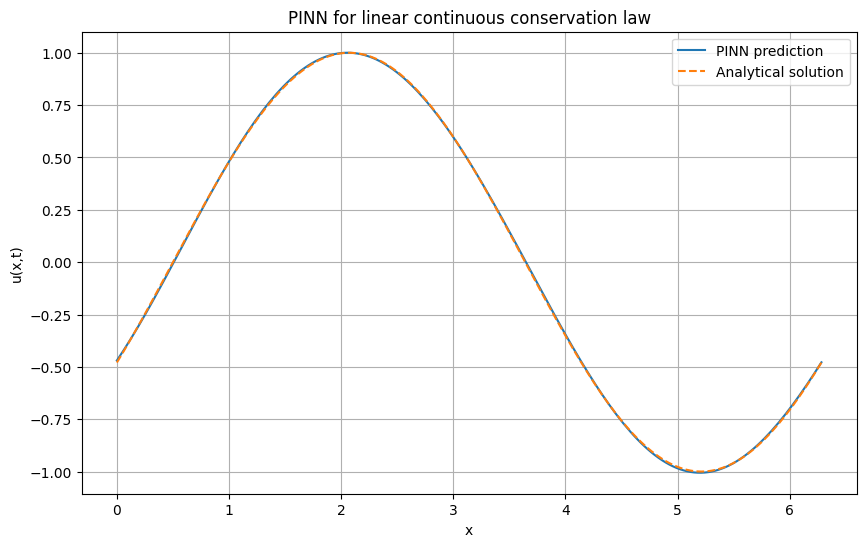

Epoch 0, Loss: 2.44402e-01, mean residual = 6.09e-01
Epoch 100, Loss: -3.09532e-01, mean residual = 3.58e-02
Epoch 200, Loss: -6.27108e-01, mean residual = 7.79e-03
Epoch 300, Loss: -9.34998e-01, mean residual = 6.62e-03
Epoch 400, Loss: -1.24031e+00, mean residual = 4.42e-03
Epoch 500, Loss: -1.54376e+00, mean residual = 4.35e-03
Epoch 600, Loss: -1.83333e+00, mean residual = 8.77e-03
Epoch 700, Loss: -2.14897e+00, mean residual = 3.27e-03
Epoch 800, Loss: -2.45060e+00, mean residual = 3.54e-03
Epoch 900, Loss: -2.75147e+00, mean residual = 3.73e-03
Epoch 1000, Loss: -3.04524e+00, mean residual = 4.07e-03
Epoch 1100, Loss: -3.35416e+00, mean residual = 3.46e-03
Epoch 1200, Loss: -3.65478e+00, mean residual = 3.55e-03
Epoch 1300, Loss: -3.95519e+00, mean residual = 3.76e-03
Epoch 1400, Loss: -4.25535e+00, mean residual = 3.70e-03
Epoch 1500, Loss: -4.55525e+00, mean residual = 3.85e-03
time for LBPINN: 7.738377809524536 seconds
mean residual = 3.85e-03


In [10]:
l = 0
r = 2*torch.pi
T = 0.5
u0_func = lambda x: torch.sin(x)
u_true_func = lambda x, t: np.sin(x-t)
model_pinn, errors_pinn = solve_pde_with_pinn(u0_func, u_true_func, l, r, T, f=lambda u: u, epochs=1500)
model_lb, errors_lb = solve_pde_with_lbpinn(u0_func, u_true_func, l, r, T, f=lambda u: u, epochs=1500)

time for LF: 0.0015368461608886719 seconds
error for LF: 0.011253658730442189
time for LW: 0.0012540817260742188 seconds
error for LW: 0.003916553721028082


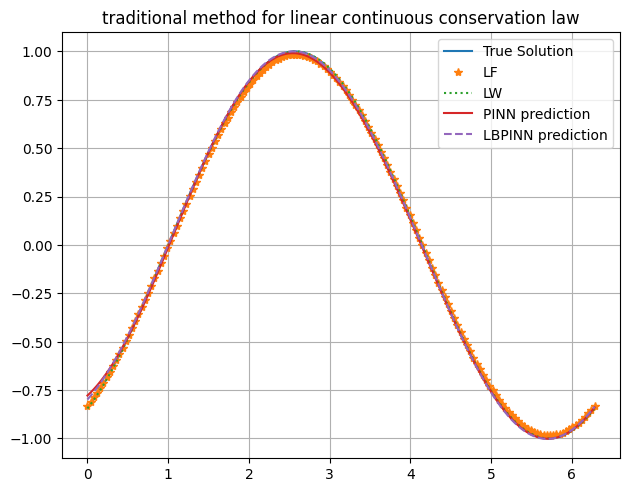

In [17]:
import matplotlib.pyplot as plt
u_0 = lambda x: np.sin(x)
f = lambda u: u
diff_f = lambda u: 1
x_plot = np.linspace(0, 2*np.pi, 160)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.plot(x_plot, u_0(x_plot-1), label='True Solution')
for method, style in zip(['LF', 'LW'], ['*', ':']):
    start_time = time.time()
    result = Conservation(u_0, 160, 160, 0, 2*np.pi, 1, f, diff_f=diff_f, method=method, boundary='periodic')
    end_time = time.time()
    print(f"time for {method}: {end_time-start_time} seconds")
    error = np.mean(np.abs(result-u_0(np.linspace(0, 2*np.pi, 160)-1)))
    print(f"error for {method}: {error}")
    plt.plot(x_plot,result, style, label=method)
plt.plot(x_plot, model_pinn(torch.tensor(x_plot).to(torch.float32).reshape(-1,1).to(device), torch.ones(160,1).to(device)).detach().cpu().numpy(), label='PINN prediction')
plt.plot(x_plot, model_lb(torch.tensor(x_plot).to(torch.float32).reshape(-1,1).to(device), torch.ones(160,1).to(device)).detach().cpu().numpy(), '--', label='LBPINN prediction')
plt.legend()
plt.tight_layout()
plt.title('traditional method for linear continuous conservation law')
plt.grid(True)
plt.savefig('conservation.png')

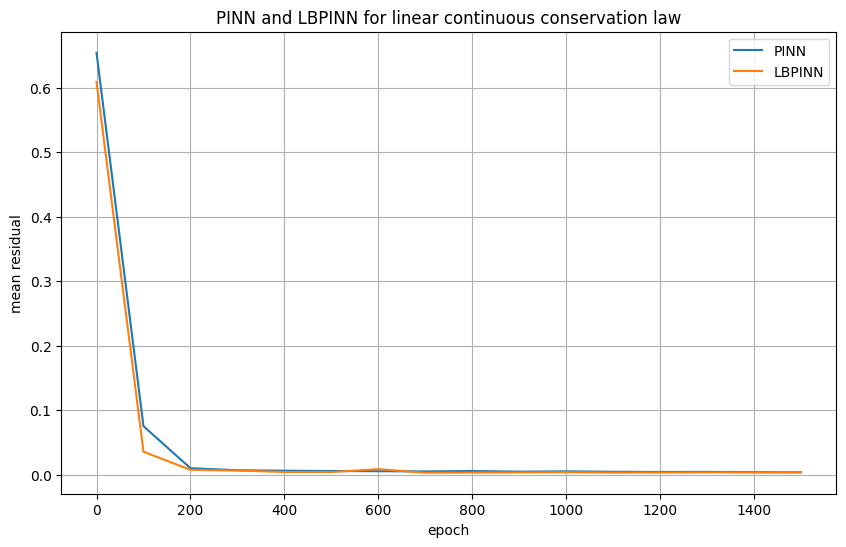

In [18]:
plt.figure(figsize=(10, 6))
plt.title('PINN and LBPINN for linear continuous conservation law')
plt.xlabel('epoch')
plt.ylabel('mean residual')
plt.plot(np.arange(len(errors_pinn))*100, errors_pinn)
plt.plot(np.arange(len(errors_lb))*100, errors_lb)
plt.legend(['PINN', 'LBPINN'])
plt.grid(True)
plt.savefig('lbpinn_linear_continuous_errors.png')
plt.show()

In [35]:
l = -1.0
r = 1.0
T = 0.5
u0_func = lambda x: torch.where(x<0.0, 0.0, 1.0)
u_true_func = lambda x, t: np.where(x-t<0.0, 0.0, 1.0)
model_pinn, errors_pinn = solve_pde_with_pinn(u0_func, u_true_func, l, r, T, f=lambda u: u, epochs=3000, boundary='Dirichlet', b_l=0.0, b_r=1.0)
model_lb, errors_lb = solve_pde_with_lbpinn(u0_func, u_true_func, l, r, T, f=lambda u: u, epochs=3000, boundary='Dirichlet', b_l=0.0, b_r=1.0)

Epoch 0, Loss: 1.81895e+00, mean residual = 3.17e-01
Epoch 100, Loss: 9.60240e-02, mean residual = 2.44e-01
Epoch 200, Loss: 8.96040e-02, mean residual = 2.30e-01
Epoch 300, Loss: 8.62334e-02, mean residual = 2.21e-01
Epoch 400, Loss: 7.89731e-02, mean residual = 2.05e-01
Epoch 500, Loss: 5.89172e-02, mean residual = 1.75e-01
Epoch 600, Loss: 3.33779e-02, mean residual = 1.23e-01
Epoch 700, Loss: 2.30794e-02, mean residual = 9.25e-02
Epoch 800, Loss: 1.61419e-02, mean residual = 6.94e-02
Epoch 900, Loss: 1.24909e-02, mean residual = 5.64e-02
Epoch 1000, Loss: 1.05979e-02, mean residual = 5.13e-02
Epoch 1100, Loss: 9.29743e-03, mean residual = 4.60e-02
Epoch 1200, Loss: 8.21196e-03, mean residual = 4.03e-02
Epoch 1300, Loss: 7.28891e-03, mean residual = 3.52e-02
Epoch 1400, Loss: 6.51700e-03, mean residual = 3.09e-02
Epoch 1500, Loss: 5.89071e-03, mean residual = 2.78e-02
Epoch 1600, Loss: 5.37980e-03, mean residual = 2.64e-02
Epoch 1700, Loss: 4.97304e-03, mean residual = 2.55e-02
Epoc

time for LF: 0.003015279769897461 seconds
error for LF: 0.019291927515597378
time for LW: 0.002766847610473633 seconds
error for LW: 0.014348871898454902


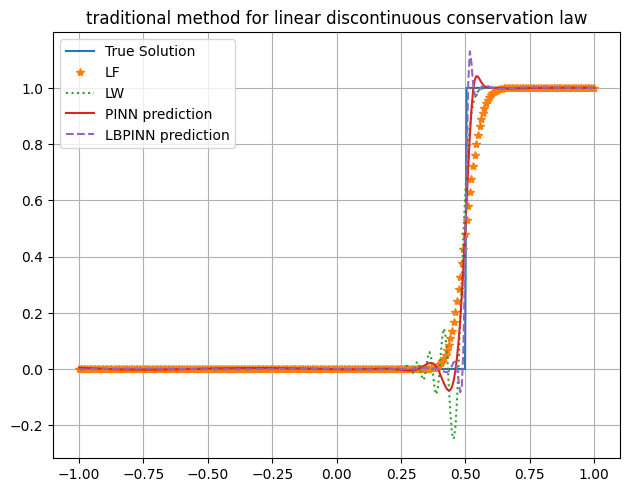

In [36]:
u_0 = lambda x: np.where(x<0.0, 0.0, 1.0)
f = lambda u: u
diff_f = lambda u: 1
T = 0.5
x_plot = np.linspace(-1, 1, 320)
plt.plot(x_plot, np.where(x_plot<T, 0.0, 1.0), label='True Solution')
for method, style in zip(['LF', 'LW'], ['*', ':']):
    start_time = time.time()
    result = Conservation(u_0, 320, 320, -1, 1, 0.5, f, diff_f=diff_f, method=method, boundary='Dirichlet')
    end_time = time.time()
    print(f"time for {method}: {end_time-start_time} seconds")
    error = np.mean(np.abs(result-np.where(x_plot<T, 0.0, 1.0)))
    print(f"error for {method}: {error}")
    plt.plot(x_plot, result, style, label=method)
plt.plot(x_plot, model_pinn(torch.tensor(x_plot).to(torch.float32).reshape(-1,1).to(device), 0.5*torch.ones(320,1).to(device)).detach().cpu().numpy(), label='PINN prediction')
plt.plot(x_plot, model_lb(torch.tensor(x_plot).to(torch.float32).reshape(-1,1).to(device), 0.5*torch.ones(320,1).to(device)).detach().cpu().numpy(), '--', label='LBPINN prediction')
plt.legend()
plt.tight_layout()
plt.title('traditional method for linear discontinuous conservation law')
plt.grid(True)
plt.savefig('conservation_linear_discontinuous.png')

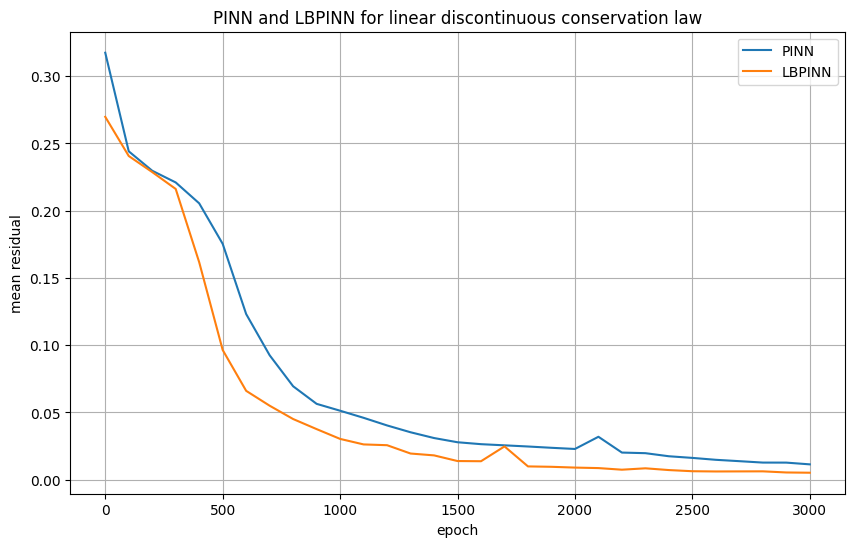

In [38]:
plt.figure(figsize=(10, 6))
plt.title('PINN and LBPINN for linear discontinuous conservation law')
plt.xlabel('epoch')
plt.ylabel('mean residual')
plt.plot(np.arange(len(errors_pinn))*100, errors_pinn)
plt.plot(np.arange(len(errors_lb))*100, errors_lb)
plt.legend(['PINN', 'LBPINN'])
plt.grid(True)
plt.savefig('lbpinn_linear_discontinuous_errors.png')
plt.show()

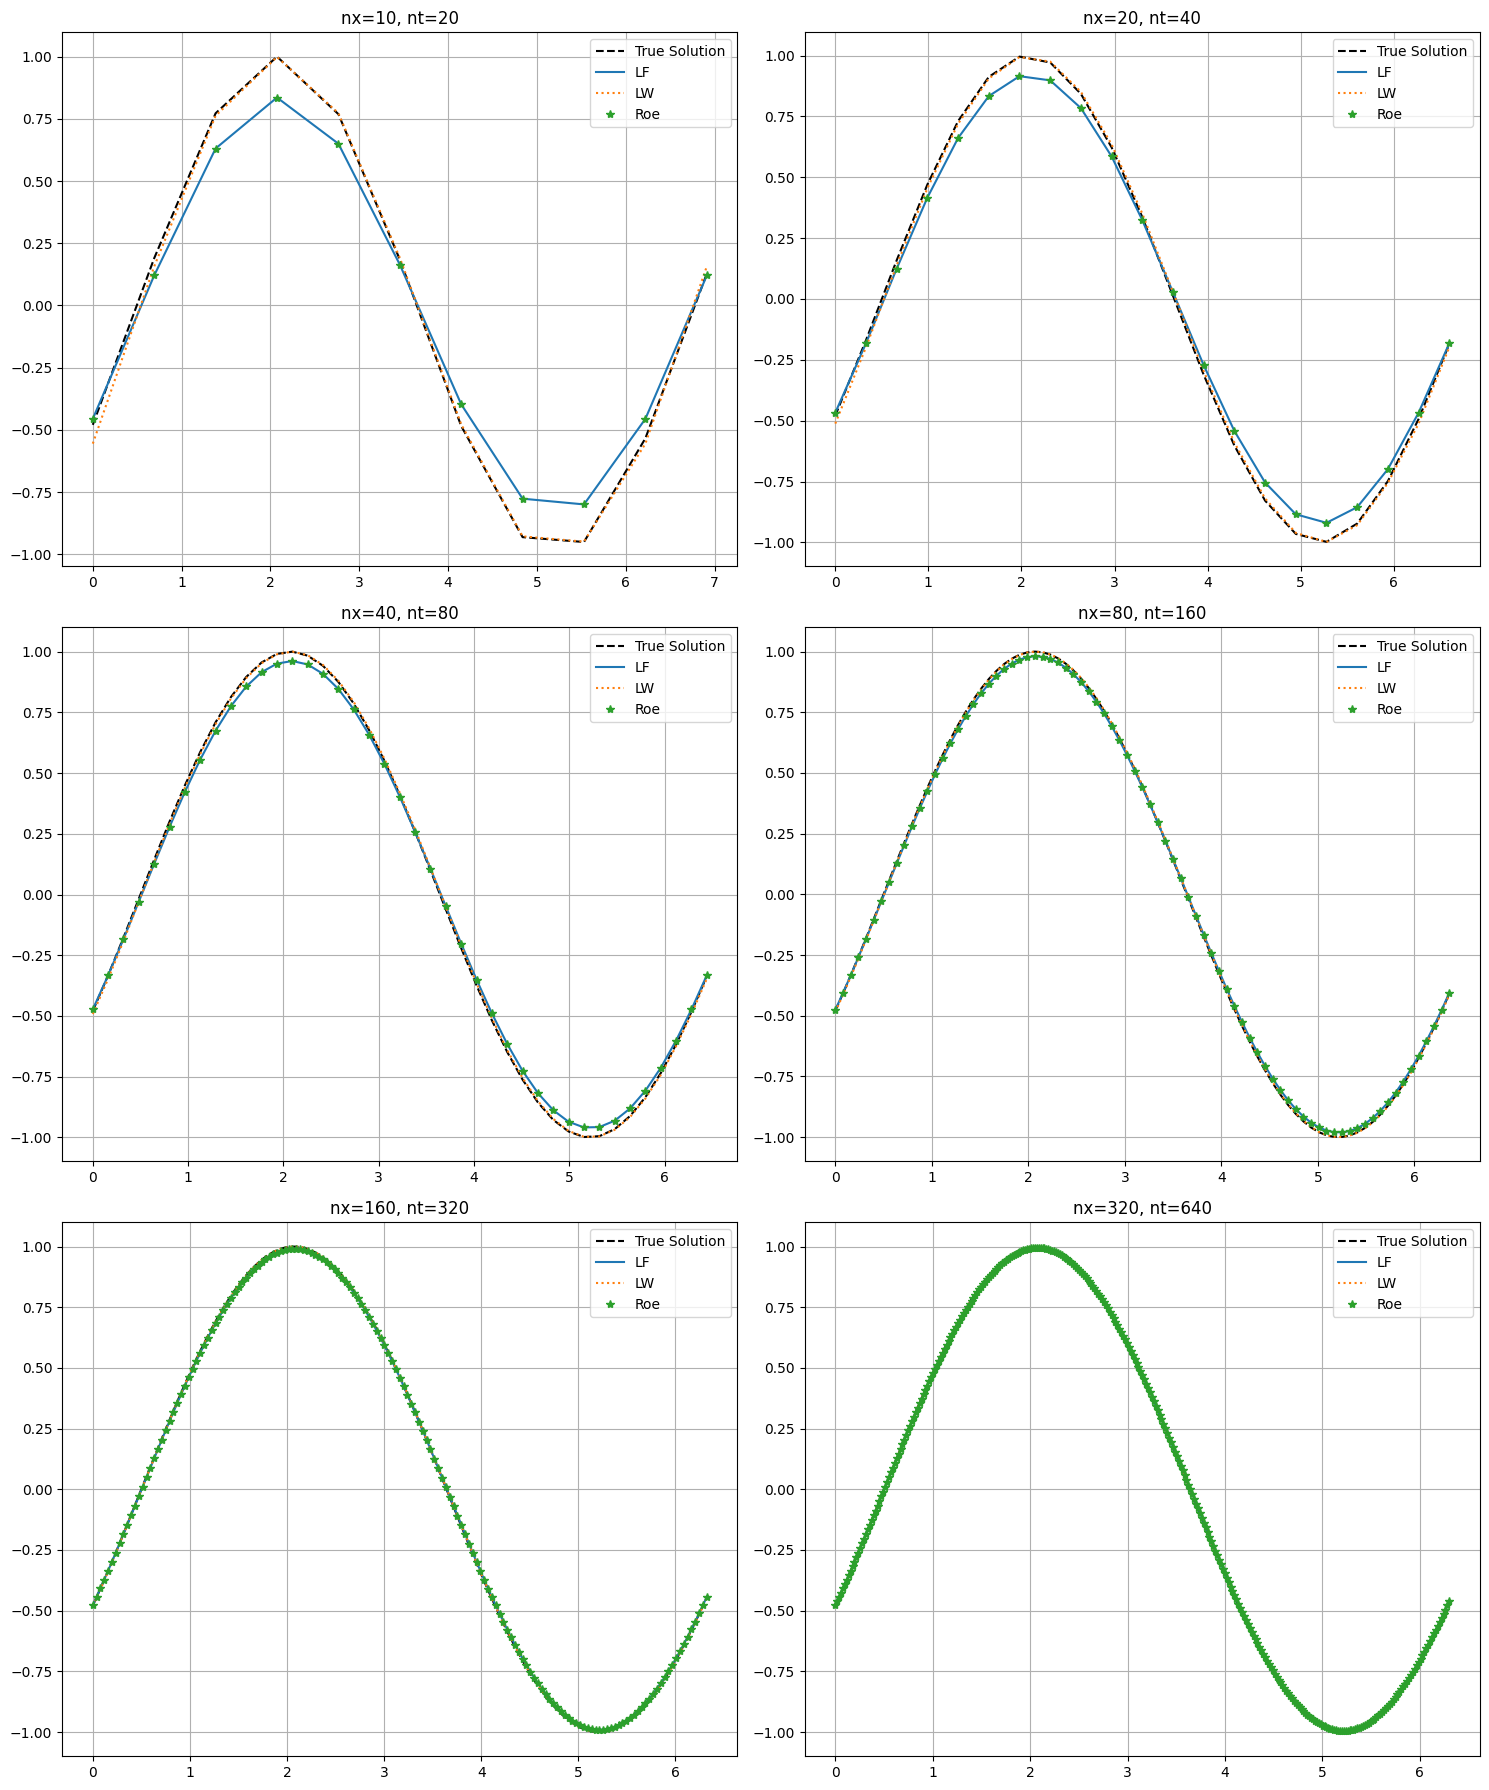

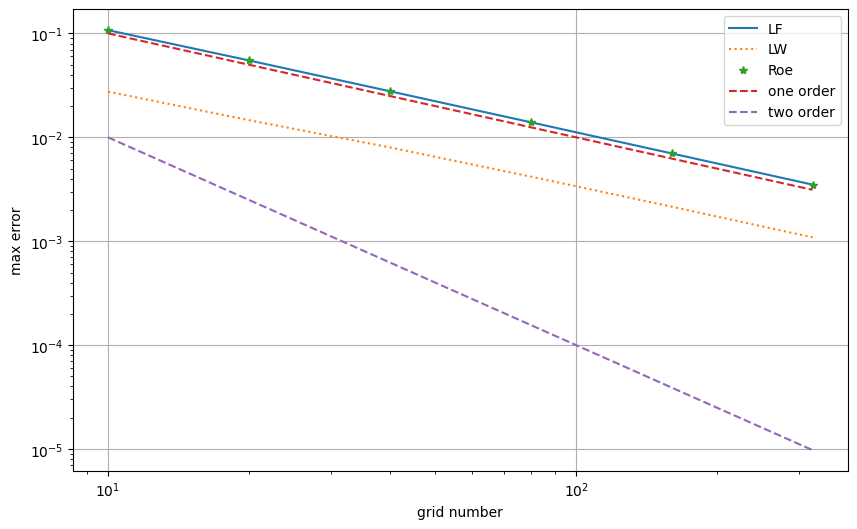

In [4]:
import matplotlib.pyplot as plt

def Conservation_linear(u_0, T, l, r, boundary='periodic'):
    f = lambda u: u
    diff_f = lambda u: 1

    # 计算不同网格大小下的误差
    nx_list = [10, 20, 40, 80, 160, 320]
    nt_list = [20, 40, 80, 160, 320, 640]
    error_dict = {'LF':[], 'LW':[], 'Roe':[], 'Godunov':[]}

    fig, axs = plt.subplots(3, 2, figsize=(15, 18))
    axs = axs.ravel()
    
    
    for i, (nx, nt) in enumerate(zip(nx_list, nt_list)):
        x = np.linspace(l, r+(r-l)/nx, nx+1)
        u_true = u_0(x-T)
        axs[i].plot(x, u_true, 'k--', label='True Solution')
        for method, style in zip(['LF', 'LW', 'Roe'], ['-', ':', '*']):
            result = Conservation(u_0, nx, nt, l, r, T, f, diff_f=diff_f, method=method, boundary=boundary)
            axs[i].plot(x, result, style, label=method)
            error = np.sqrt(np.mean((result - u_true)**2))
            error_dict[method].append(error)
            
        axs[i].set_title(f'nx={nx}, nt={nt}')
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()

    # 绘制误差收敛图像
    plt.figure(figsize=(10,6))
    for method, style in zip(['LF', 'LW', 'Roe'], ['-', ':', '*']):
        plt.loglog(nx_list, error_dict[method], style, label=method)
    plt.loglog(nx_list, [1/nx for nx in nx_list], '--', label='one order')
    plt.loglog(nx_list, [1/nx**2 for nx in nx_list], '--', label='two order')
    plt.xlabel('grid number')
    plt.ylabel('max error')
    plt.legend()
    plt.grid(True)
    plt.show()

u_0 = lambda x: np.sin(x)
Conservation_linear(u_0, 0.5, 0, 2*np.pi)

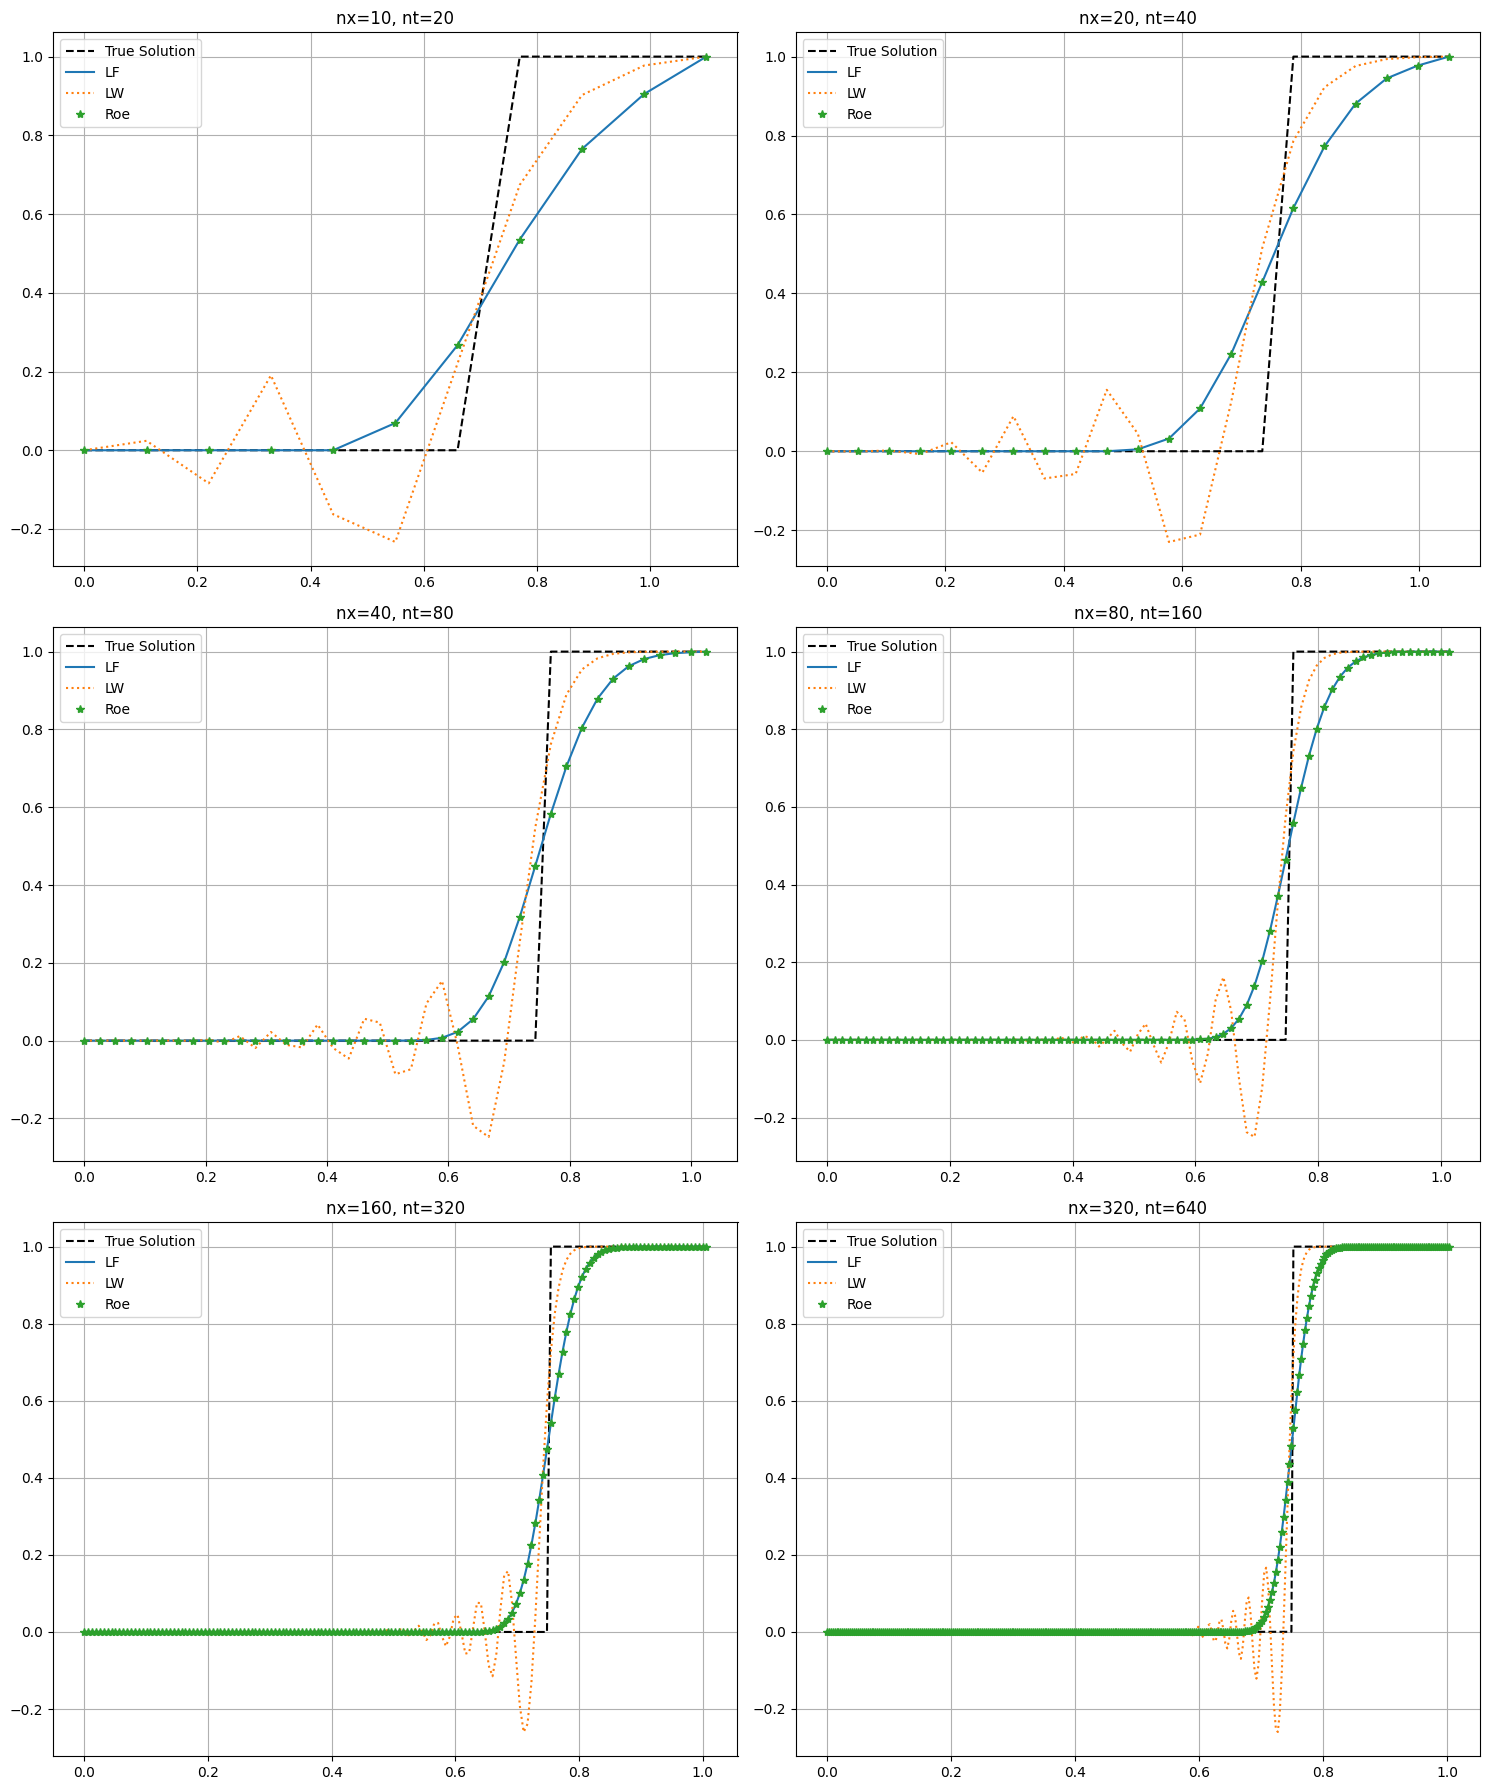

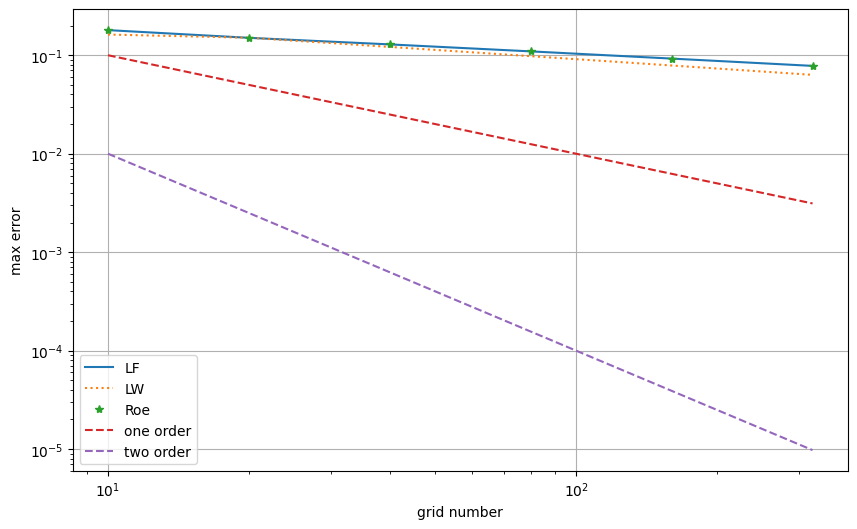

In [5]:
u_0 = lambda x: np.where(x<0.5, 0.0, 1.0)
Conservation_linear(u_0, 0.25, 0, 1, boundary=None)

接下来使用深度学习方法求解上述线性方程

Epoch 0, Loss: 1.28650e+00, mean residual = 2.99e-01
Epoch 100, Loss: 9.22058e-02, mean residual = 2.37e-01
Epoch 200, Loss: 8.58268e-02, mean residual = 2.21e-01
Epoch 300, Loss: 7.90966e-02, mean residual = 2.06e-01
Epoch 400, Loss: 6.46691e-02, mean residual = 1.80e-01
Epoch 500, Loss: 3.17128e-02, mean residual = 1.21e-01
Epoch 600, Loss: 1.91783e-02, mean residual = 7.94e-02
Epoch 700, Loss: 1.40874e-02, mean residual = 6.17e-02
Epoch 800, Loss: 1.10530e-02, mean residual = 5.24e-02
Epoch 900, Loss: 9.33859e-03, mean residual = 4.70e-02
Epoch 1000, Loss: 8.13905e-03, mean residual = 4.07e-02
Epoch 1100, Loss: 7.16672e-03, mean residual = 3.56e-02
Epoch 1200, Loss: 6.41072e-03, mean residual = 3.27e-02
Epoch 1300, Loss: 5.81753e-03, mean residual = 3.09e-02
Epoch 1400, Loss: 5.32747e-03, mean residual = 2.94e-02
Epoch 1500, Loss: 4.90520e-03, mean residual = 2.75e-02
Epoch 1600, Loss: 4.53470e-03, mean residual = 2.66e-02
Epoch 1700, Loss: 4.19653e-03, mean residual = 2.44e-02
Epoc

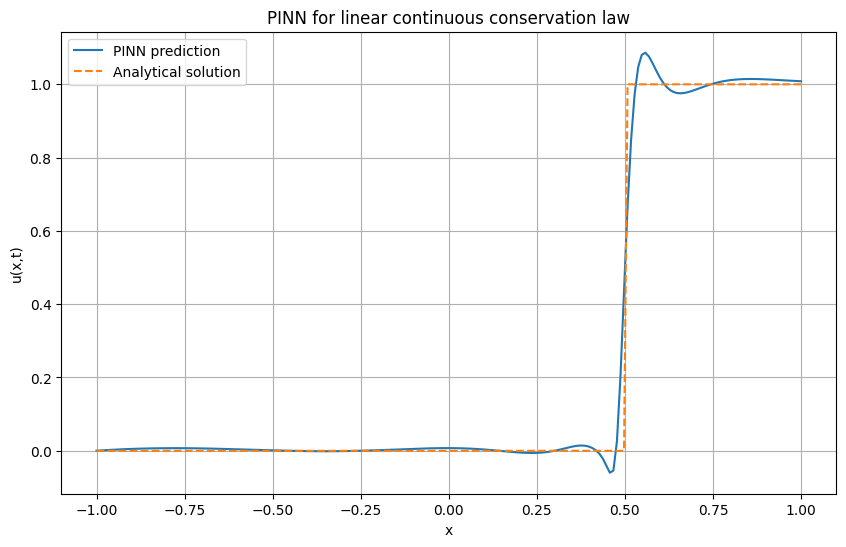

Epoch 0, Loss: 7.62470e-01, mean residual = 2.50e-01
Epoch 100, Loss: -2.62276e-01, mean residual = 2.40e-01
Epoch 200, Loss: -5.64810e-01, mean residual = 2.26e-01
Epoch 300, Loss: -8.60125e-01, mean residual = 2.11e-01
Epoch 400, Loss: -1.17169e+00, mean residual = 1.75e-01
Epoch 500, Loss: -1.50549e+00, mean residual = 1.01e-01
Epoch 600, Loss: -1.81994e+00, mean residual = 7.45e-02
Epoch 700, Loss: -2.13584e+00, mean residual = 5.28e-02
Epoch 800, Loss: -2.44625e+00, mean residual = 3.94e-02
Epoch 900, Loss: -2.75440e+00, mean residual = 3.12e-02
Epoch 1000, Loss: -3.06070e+00, mean residual = 2.62e-02
Epoch 1100, Loss: -3.36538e+00, mean residual = 2.43e-02
Epoch 1200, Loss: -3.67011e+00, mean residual = 1.96e-02
Epoch 1300, Loss: -3.97357e+00, mean residual = 1.67e-02
Epoch 1400, Loss: -4.27702e+00, mean residual = 1.44e-02
Epoch 1500, Loss: -4.57975e+00, mean residual = 1.28e-02
Epoch 1600, Loss: -4.88234e+00, mean residual = 1.10e-02
Epoch 1700, Loss: -5.18507e+00, mean residua

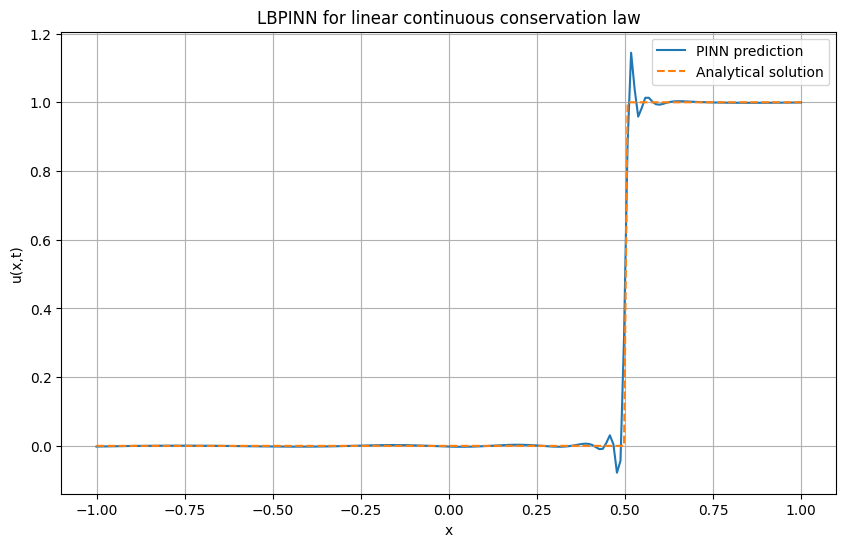

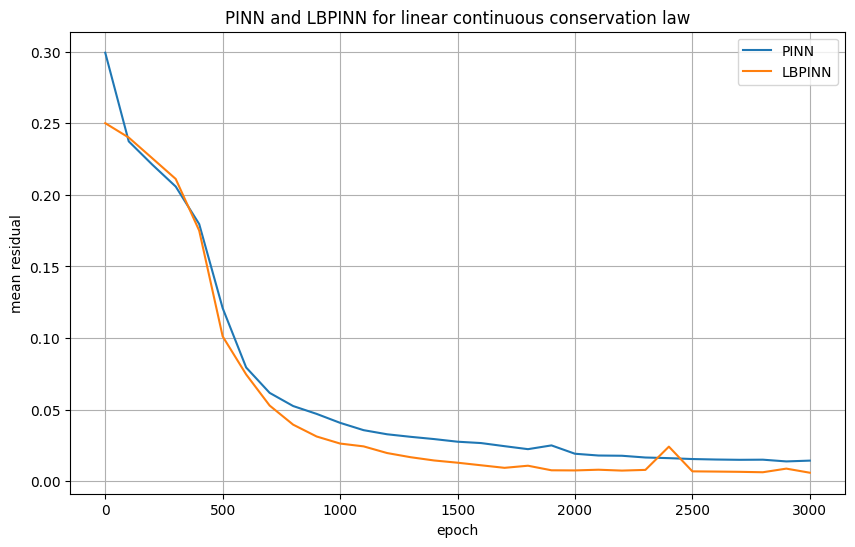

我们令$f(u)=\frac{u^2}{2}$，则方程变为：  
$$ u_t + (\frac{u^2}{2})_x = 0 $$
将上述传统方法运用到该非线性方程中，并进行可视化

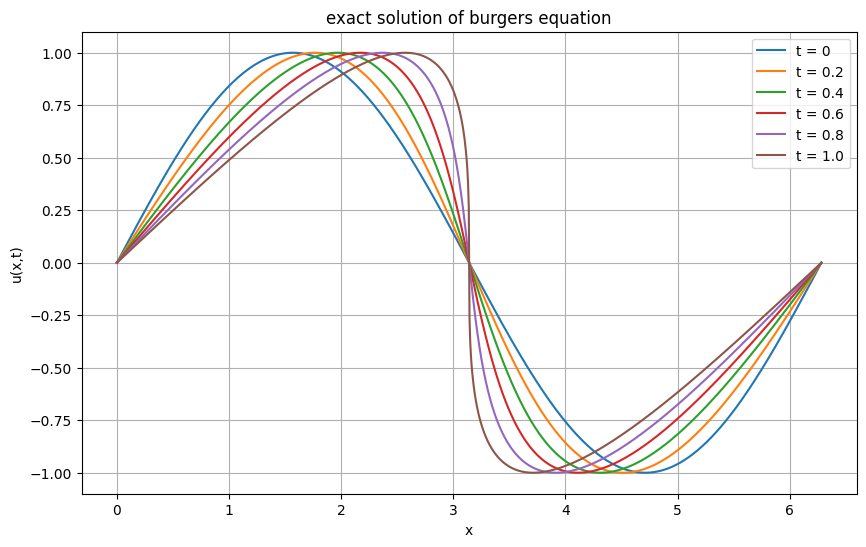

In [24]:
import numpy as np
import scipy.optimize as opt

def exact_solution_burgers(x, t, u0_func=None):
    """
    求解一般Burgers方程的精确解
    
    参数:
        x: 空间点坐标数组
        t: 时间点
        u0_func: 初始条件函数，默认为sin(π*x+π)
    
    返回:
        u: 在点x和时间t的精确解
    """
    if u0_func is None:
        # 默认初始条件
        u0_func = lambda x0: np.sin(x0)
    
    # 如果x是单个值，转为数组方便处理
    if np.isscalar(x):
        x = np.array([x])
    
    # 初始化结果数组
    u = np.zeros_like(x, dtype=float)
    
    # 对每个空间点求解特征线方程
    for i in range(len(x)):
        # 定义要求解的特征线方程: x - x0 - t*u0(x0) = 0
        def f_char(x0):
            return (x[i] - x0) - t * u0_func(x0)
        
        # 使用二分法求解方程，需要找到适当的搜索区间
        # 因为特征线可能会相交(形成激波)，我们需要仔细处理
        
        # 首先尝试在较大范围内寻找解
        x_min, x_max = -2.0, 2.0
        
        # 检查区间端点的函数值符号是否相反
        f_min, f_max = f_char(x_min), f_char(x_max)
        
        try:
            # 如果函数值符号相反，可以使用二分法
            if f_min * f_max <= 0:
                x0_sol = opt.bisect(f_char, x_min, x_max)
                u[i] = u0_func(x0_sol)
            else:
                # 如果函数值符号相同，尝试寻找使函数值为零的点
                x0_sol = opt.newton(f_char, 0.0, maxiter=100)
                
                # 验证解的有效性
                if abs(f_char(x0_sol)) < 1e-10:
                    u[i] = u0_func(x0_sol)
                else:
                    # 尝试多个初始猜测点
                    valid_solution = False
                    for guess in np.linspace(x_min, x_max, 20):
                        try:
                            x0_candidate = opt.newton(f_char, guess, maxiter=50)
                            if abs(f_char(x0_candidate)) < 1e-10:
                                u[i] = u0_func(x0_candidate)
                                valid_solution = True
                                break
                        except:
                            continue
                    
                    if not valid_solution:
                        # 可能是激波区域，选择满足熵条件的解
                        u[i] = np.nan  # 标记为未找到解，后续处理
        except:
            # 数值求解失败，可能是在激波区域
            u[i] = np.nan
    
    # 处理激波区域 (这里采用简单标记，实际应用中需要更复杂的处理)
    # 如果有更多关于激波区域的信息，可以进一步完善
    nan_mask = np.isnan(u)
    if np.any(nan_mask):
        print(f"警告: 在时间 t={t} 发现可能的激波区域")
    
    return u

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    # 测试函数
    x = np.linspace(0, 2*np.pi, 1000)
    
    # 不同时间点的解
    times = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    
    plt.figure(figsize=(10, 6))
    
    for t in times:
        try:
            u = exact_solution_burgers(x, t, u0_func=lambda x0: np.sin(x0))
            plt.plot(x, u, label=f't = {t}')
        except ValueError as e:
            print(f"t = {t}: {e}")
    
    plt.grid(True)
    plt.legend()
    plt.title('exact solution of burgers equation')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.savefig('burgers_exact_solution.png')
    plt.show()

In [25]:
l = 0
r = 2*torch.pi
T = 1
u0_func = lambda x: torch.sin(x)
model_pinn, errors_pinn = solve_pde_with_pinn(u0_func, exact_solution_burgers, l, r, T, f=lambda u: u**2/2, epochs=10000)
model_lb, errors_lb = solve_pde_with_lbpinn(u0_func, exact_solution_burgers, l, r, T, f=lambda u: u**2/2, epochs=10000)

Epoch 0, Loss: 5.68574e-01, mean residual = 6.49e-01
Epoch 100, Loss: 8.22521e-02, mean residual = 3.09e-01
Epoch 200, Loss: 5.47398e-02, mean residual = 2.47e-01
Epoch 300, Loss: 5.05397e-02, mean residual = 2.28e-01
Epoch 400, Loss: 4.40552e-02, mean residual = 2.09e-01
Epoch 500, Loss: 3.33108e-02, mean residual = 1.89e-01
Epoch 600, Loss: 2.50084e-02, mean residual = 1.57e-01
Epoch 700, Loss: 1.74740e-02, mean residual = 1.21e-01
Epoch 800, Loss: 1.37307e-02, mean residual = 9.94e-02
Epoch 900, Loss: 1.16499e-02, mean residual = 9.28e-02
Epoch 1000, Loss: 1.03941e-02, mean residual = 8.75e-02
Epoch 1100, Loss: 8.92610e-03, mean residual = 8.26e-02
Epoch 1200, Loss: 7.51603e-03, mean residual = 7.60e-02
Epoch 1300, Loss: 6.87147e-03, mean residual = 7.07e-02
Epoch 1400, Loss: 5.72275e-03, mean residual = 6.56e-02
Epoch 1500, Loss: 5.40833e-03, mean residual = 6.15e-02
Epoch 1600, Loss: 5.23258e-03, mean residual = 5.87e-02
Epoch 1700, Loss: 4.59213e-03, mean residual = 5.70e-02
Epoc

time for LF: 0.0020570755004882812 seconds
error for LF: 0.020781787553086184
time for LW: 0.0019338130950927734 seconds
error for LW: 0.005254255874772559
time for Roe: 0.002432107925415039 seconds
error for Roe: 0.008814357494926827
time for Godunov: 0.001157999038696289 seconds
error for Godunov: 0.008814343158658495


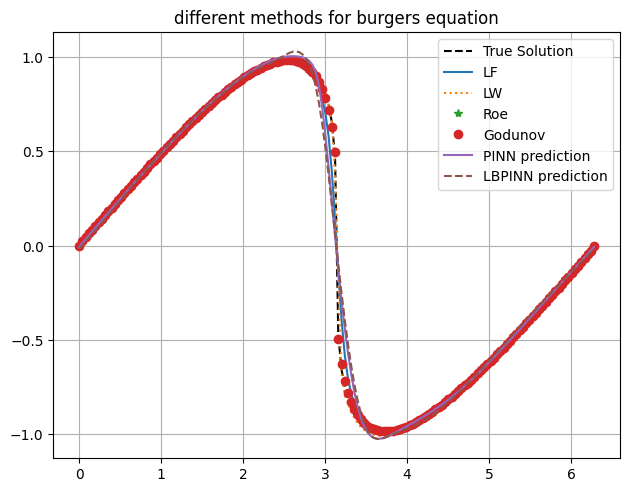

In [32]:
f = lambda u: u**2/2
diff_f = lambda u: u
nx =160
nt = 160
x = np.linspace(l, r, nx)
u0 = lambda x: np.sin(x)
u_true = exact_solution_burgers(x, T)
plt.plot(x, u_true, 'k--', label='True Solution')
for method, style in zip(['LF', 'LW', 'Roe', 'Godunov'], ['-', ':', '*', 'o']):
    start_time = time.time()
    result = Conservation(u0, nx, nt, l, r, T, f, diff_f=diff_f, method=method)
    end_time = time.time()
    print(f"time for {method}: {end_time-start_time} seconds")
    plt.plot(x, result, style, label=method)
    error = np.mean(np.abs(result-u_true))
    print(f"error for {method}: {error}")
plt.plot(x, model_pinn(torch.tensor(x).to(torch.float32).reshape(-1,1).to(device), torch.ones(nx,1).to(device)).detach().cpu().numpy(), label='PINN prediction')
plt.plot(x, model_lb(torch.tensor(x).to(torch.float32).reshape(-1,1).to(device), torch.ones(nx,1).to(device)).detach().cpu().numpy(), '--', label='LBPINN prediction')
plt.legend()
plt.tight_layout()
plt.title('different methods for burgers equation')
plt.grid(True)
plt.savefig('burgers_continuous.png')

In [51]:
l = -1  
r = 1
T = 0.5
u0_func = lambda x: torch.where(x<0.0, 1.0, 0.0)
u_true = lambda x, t: np.where(x<t/2, 1.0, 0.0)
model_pinn, errors_pinn = solve_pde_with_pinn(u0_func, u_true, l, r, T, f=lambda u: u**2/2, boundary='Dirichlet', b_l=1.0, b_r=0.0, epochs=5000)
model_lb, errors_lb = solve_pde_with_lbpinn(u0_func, u_true, l, r, T, f=lambda u: u**2/2, boundary='Dirichlet', b_l=1.0, b_r=0.0, epochs=5000)

Epoch 0, Loss: 1.61343e+00, mean residual = 6.49e-01
Epoch 100, Loss: 9.25733e-02, mean residual = 2.24e-01
Epoch 200, Loss: 9.10508e-02, mean residual = 2.18e-01
Epoch 300, Loss: 8.92820e-02, mean residual = 2.16e-01
Epoch 400, Loss: 8.64190e-02, mean residual = 2.11e-01
Epoch 500, Loss: 7.90635e-02, mean residual = 1.96e-01
Epoch 600, Loss: 5.94638e-02, mean residual = 1.37e-01
Epoch 700, Loss: 4.96077e-02, mean residual = 1.05e-01
Epoch 800, Loss: 4.24862e-02, mean residual = 8.55e-02
Epoch 900, Loss: 3.77579e-02, mean residual = 6.99e-02
Epoch 1000, Loss: 3.55120e-02, mean residual = 6.32e-02
Epoch 1100, Loss: 3.41811e-02, mean residual = 6.09e-02
Epoch 1200, Loss: 3.33577e-02, mean residual = 5.83e-02
Epoch 1300, Loss: 3.23915e-02, mean residual = 5.58e-02
Epoch 1400, Loss: 3.15520e-02, mean residual = 5.36e-02
Epoch 1500, Loss: 3.07678e-02, mean residual = 5.00e-02
Epoch 1600, Loss: 2.98707e-02, mean residual = 4.85e-02
Epoch 1700, Loss: 2.95688e-02, mean residual = 4.63e-02
Epoc

time for LF: 0.002162456512451172 seconds
error for LF: 0.008082872956109339
time for LW: 0.002573251724243164 seconds
error for LW: 0.007058653815058611
time for Roe: 0.0029888153076171875 seconds
error for Roe: 0.0035588143395786616
time for Godunov: 0.001260519027709961 seconds
error for Godunov: 0.0035588143381590437


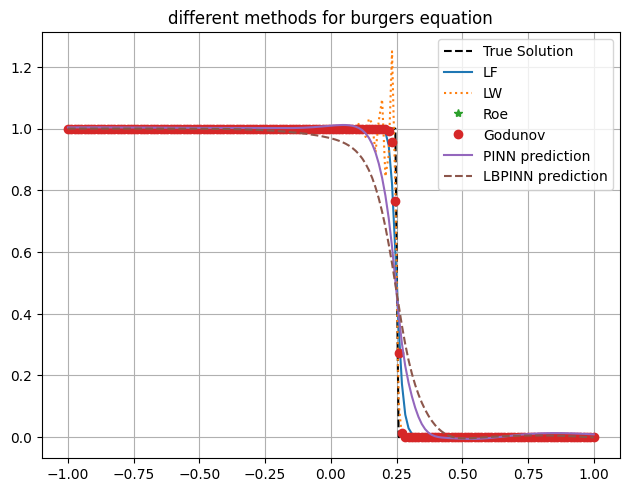

In [52]:
f = lambda u: u**2/2
diff_f = lambda u: u
nx =160
nt = 160
T = 0.5
x = np.linspace(l, r, nx)
u_0 = lambda x: np.where(x<0.0, 1.0, 0.0)
u_true = lambda x, t: np.where(x<t/2, 1.0, 0.0)
plt.plot(x, u_true(x, T), 'k--', label='True Solution')
for method, style in zip(['LF', 'LW', 'Roe', 'Godunov'], ['-', ':', '*', 'o']):
    start_time = time.time()
    result = Conservation(u_0, nx, nt, l, r, T, f, diff_f=diff_f, method=method, boundary=None)
    end_time = time.time()
    print(f"time for {method}: {end_time-start_time} seconds")
    plt.plot(x, result, style, label=method)
    error = np.mean(np.abs(result-u_true(x, T)))
    print(f"error for {method}: {error}")
plt.plot(x, model_pinn(torch.tensor(x).to(torch.float32).reshape(-1,1).to(device), T*torch.ones(nx,1).to(device)).detach().cpu().numpy(), label='PINN prediction')
plt.plot(x, model_lb(torch.tensor(x).to(torch.float32).reshape(-1,1).to(device), T*torch.ones(nx,1).to(device)).detach().cpu().numpy(), '--', label='LBPINN prediction')
plt.legend()
plt.tight_layout()
plt.title('different methods for burgers equation')
plt.grid(True)
plt.savefig('burgers_shock.png')

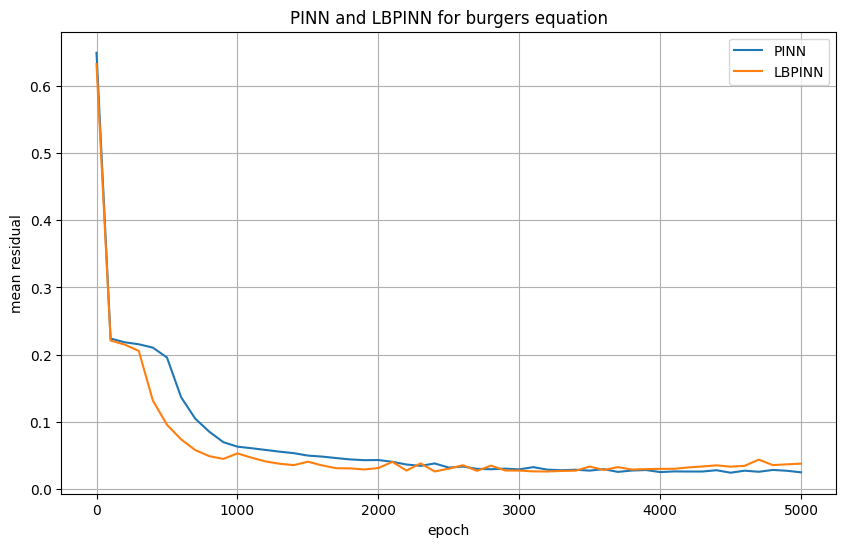

In [53]:
plt.figure(figsize=(10, 6))
plt.title('PINN and LBPINN for burgers equation')
plt.xlabel('epoch')
plt.ylabel('mean residual')
plt.plot(np.arange(len(errors_pinn))*100, errors_pinn)
plt.plot(np.arange(len(errors_lb))*100, errors_lb)
plt.legend(['PINN', 'LBPINN'])
plt.grid(True)
plt.savefig('lbpinn_burgers_errors_shock.png')
plt.show()

In [47]:
l = -1  
r = 1
T = 0.5
u0_func = lambda x: torch.where(x<0.0, 0.0, 1.0)
u_true = lambda x, t: np.where(x<0.0, 0.0, np.where(x<t, x/t, 1.0))
model_pinn, errors_pinn = solve_pde_with_pinn(u0_func, u_true, l, r, T, f=lambda u: u**2/2, boundary='Dirichlet', b_l=0.0, b_r=1.0, epochs=5000)
model_lb, errors_lb = solve_pde_with_lbpinn(u0_func, u_true, l, r, T, f=lambda u: u**2/2, boundary='Dirichlet', b_l=0.0, b_r=1.0, epochs=5000)

Epoch 0, Loss: 1.22899e+00, mean residual = 3.60e-01
Epoch 100, Loss: 9.01555e-02, mean residual = 2.04e-01
Epoch 200, Loss: 7.72225e-02, mean residual = 1.98e-01
Epoch 300, Loss: 7.32232e-02, mean residual = 1.90e-01
Epoch 400, Loss: 6.46618e-02, mean residual = 1.66e-01
Epoch 500, Loss: 5.14795e-02, mean residual = 1.28e-01
Epoch 600, Loss: 4.40358e-02, mean residual = 1.19e-01
Epoch 700, Loss: 3.90779e-02, mean residual = 1.05e-01
Epoch 800, Loss: 3.50973e-02, mean residual = 8.84e-02
Epoch 900, Loss: 3.10315e-02, mean residual = 8.01e-02
Epoch 1000, Loss: 2.64772e-02, mean residual = 7.51e-02
Epoch 1100, Loss: 2.36289e-02, mean residual = 7.21e-02
Epoch 1200, Loss: 2.22098e-02, mean residual = 6.68e-02
Epoch 1300, Loss: 2.03719e-02, mean residual = 6.04e-02
Epoch 1400, Loss: 1.91763e-02, mean residual = 5.68e-02
Epoch 1500, Loss: 1.77079e-02, mean residual = 5.26e-02
Epoch 1600, Loss: 1.66352e-02, mean residual = 5.16e-02
Epoch 1700, Loss: 1.81394e-02, mean residual = 5.02e-02
Epoc

time for LF: 0.002109527587890625 seconds
error for LF: 0.017342523988001197
time for LW: 0.0020132064819335938 seconds
error for LW: nan
time for Roe: 0.0021910667419433594 seconds
error for Roe: 0.010169067885313396
time for Godunov: 0.0011000633239746094 seconds
error for Godunov: 0.010169067885313396


/tmp/ipykernel_2262/78746565.py:1: RuntimeWarning: overflow encountered in square
  f = lambda u: u**2/2
/tmp/ipykernel_2262/33153478.py:10: RuntimeWarning: overflow encountered in multiply
  f_r = (f(un[1:-1])+f(un[2:])-lam*diff_f((un[1:-1]+un[2:])/2)*(un[2:]-un[1:-1]))/2
/tmp/ipykernel_2262/33153478.py:10: RuntimeWarning: invalid value encountered in subtract
  f_r = (f(un[1:-1])+f(un[2:])-lam*diff_f((un[1:-1]+un[2:])/2)*(un[2:]-un[1:-1]))/2
/tmp/ipykernel_2262/33153478.py:11: RuntimeWarning: overflow encountered in multiply
  f_l = (f(un[1:-1])+f(un[:-2])-lam*diff_f((un[1:-1]+un[:-2])/2)*(un[1:-1]-un[:-2]))/2
/tmp/ipykernel_2262/33153478.py:11: RuntimeWarning: invalid value encountered in subtract
  f_l = (f(un[1:-1])+f(un[:-2])-lam*diff_f((un[1:-1]+un[:-2])/2)*(un[1:-1]-un[:-2]))/2
/tmp/ipykernel_2262/659509839.py:13: RuntimeWarning: invalid value encountered in subtract
  result[1:-1] = un[1:-1] - dt/dx*(f_r - f_l)


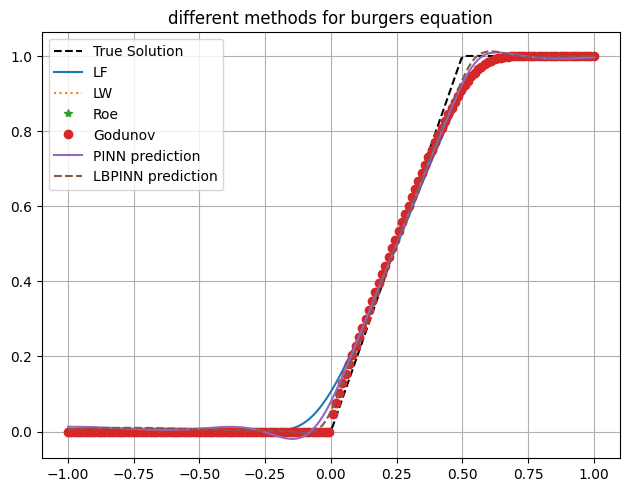

In [49]:
f = lambda u: u**2/2
diff_f = lambda u: u
nx =160
nt = 160
T = 0.5
x = np.linspace(l, r, nx)
u_0 = lambda x: np.where(x<0.0, 0.0, 1.0)
u_true = lambda x, t: np.where(x<0.0, 0.0, np.where(x<t, x/t, 1.0))
plt.plot(x, u_true(x, T), 'k--', label='True Solution')
for method, style in zip(['LF', 'LW', 'Roe', 'Godunov'], ['-', ':', '*', 'o']):
    start_time = time.time()
    result = Conservation(u_0, nx, nt, l, r, T, f, diff_f=diff_f, method=method, boundary=None)
    end_time = time.time()
    print(f"time for {method}: {end_time-start_time} seconds")
    plt.plot(x, result, style, label=method)
    error = np.mean(np.abs(result-u_true(x, T)))
    print(f"error for {method}: {error}")
plt.plot(x, model_pinn(torch.tensor(x).to(torch.float32).reshape(-1,1).to(device), T*torch.ones(nx,1).to(device)).detach().cpu().numpy(), label='PINN prediction')
plt.plot(x, model_lb(torch.tensor(x).to(torch.float32).reshape(-1,1).to(device), T*torch.ones(nx,1).to(device)).detach().cpu().numpy(), '--', label='LBPINN prediction')
plt.legend()
plt.tight_layout()
plt.title('different methods for burgers equation')
plt.grid(True)
plt.savefig('burgers_rarefaction.png')

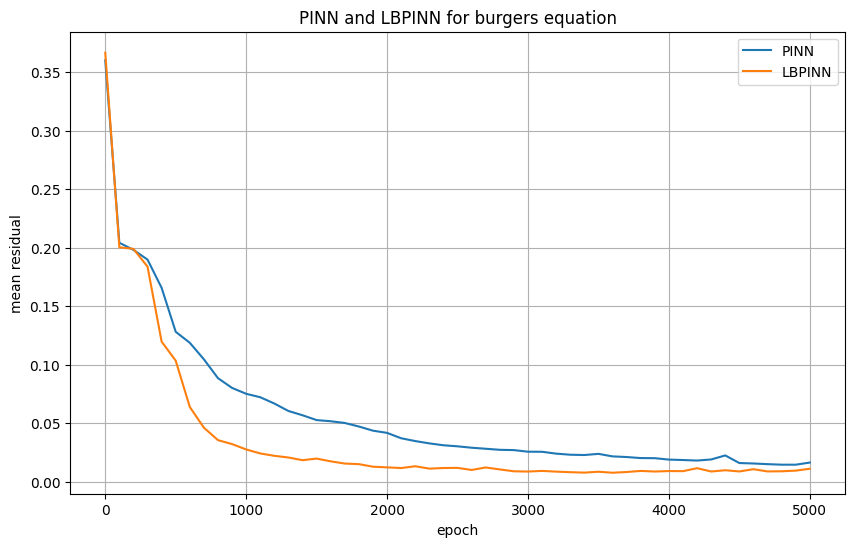

In [50]:
plt.figure(figsize=(10, 6))
plt.title('PINN and LBPINN for burgers equation')
plt.xlabel('epoch')
plt.ylabel('mean residual')
plt.plot(np.arange(len(errors_pinn))*100, errors_pinn)
plt.plot(np.arange(len(errors_lb))*100, errors_lb)
plt.legend(['PINN', 'LBPINN'])
plt.grid(True)
plt.savefig('lbpinn_burgers_errors_rarefaction.png')
plt.show()

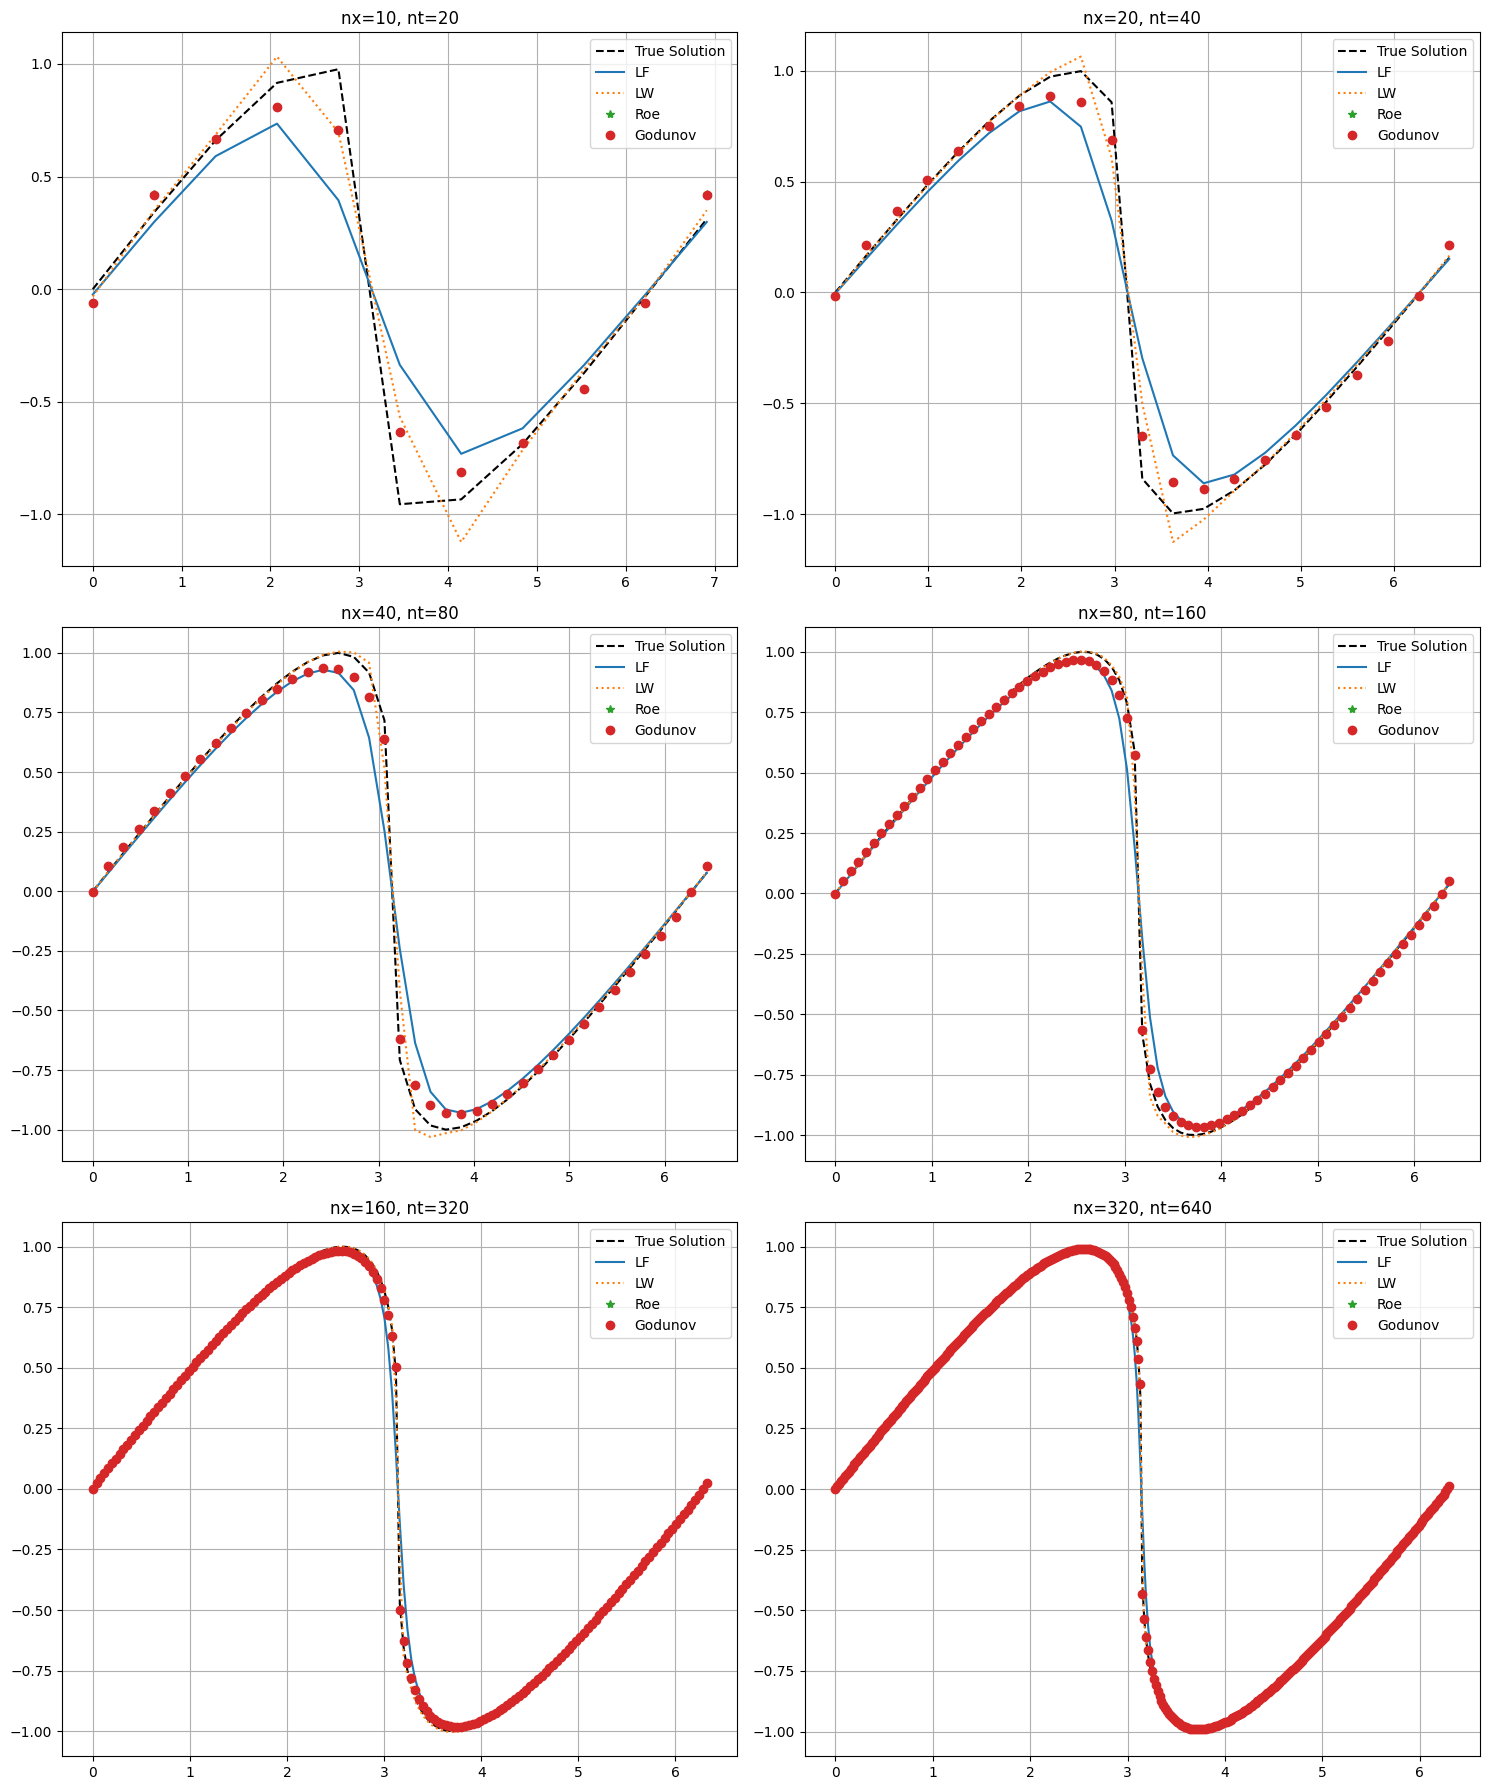

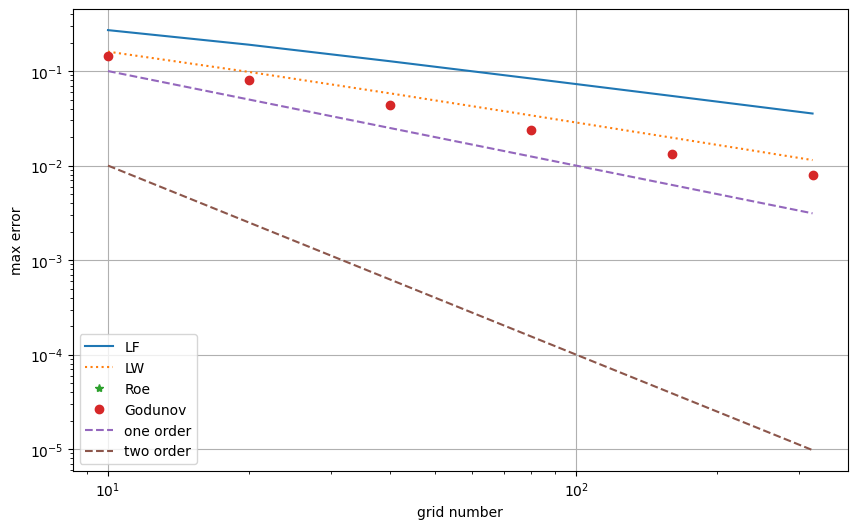

In [14]:
def Conservation_burgers(u_0, T, l, r, boundary='periodic', exact_solution=exact_solution_burgers):
    f = lambda u: u**2/2
    diff_f = lambda u: u

    # 计算不同网格大小下的误差
    nx_list = [10, 20, 40, 80, 160, 320]
    nt_list = [20, 40, 80, 160, 320, 640]
    error_dict = {'LF':[], 'LW':[], 'Roe':[], 'Godunov':[]}

    fig, axs = plt.subplots(3, 2, figsize=(15, 18))
    axs = axs.ravel()
    
    
    for i, (nx, nt) in enumerate(zip(nx_list, nt_list)):
        x = np.linspace(l, r+(r-l)/nx, nx+1)
        u_true = exact_solution(x, T)
        axs[i].plot(x, u_true, 'k--', label='True Solution')
        for method, style in zip(['LF', 'LW', 'Roe', 'Godunov'], ['-', ':', '*', 'o']):
            result = Conservation(u_0, nx, nt, l, r, T, f, diff_f=diff_f, method=method, boundary=boundary)
            axs[i].plot(x, result, style, label=method)
            error = np.sqrt(np.mean((result - u_true)**2))
            error_dict[method].append(error)
            
        axs[i].set_title(f'nx={nx}, nt={nt}')
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()

    # 绘制误差收敛图像
    plt.figure(figsize=(10,6))
    for method, style in zip(['LF', 'LW', 'Roe', 'Godunov'], ['-', ':', '*', 'o']):
        plt.loglog(nx_list, error_dict[method], style, label=method)
    plt.loglog(nx_list, [1/nx for nx in nx_list], '--', label='one order')
    plt.loglog(nx_list, [1/nx**2 for nx in nx_list], '--', label='two order')
    plt.xlabel('grid number')
    plt.ylabel('max error')
    plt.legend()
    plt.grid(True)
    plt.show()

u_0 = lambda x: np.sin(x)
Conservation_burgers(u_0, 1, 0, 2*np.pi)

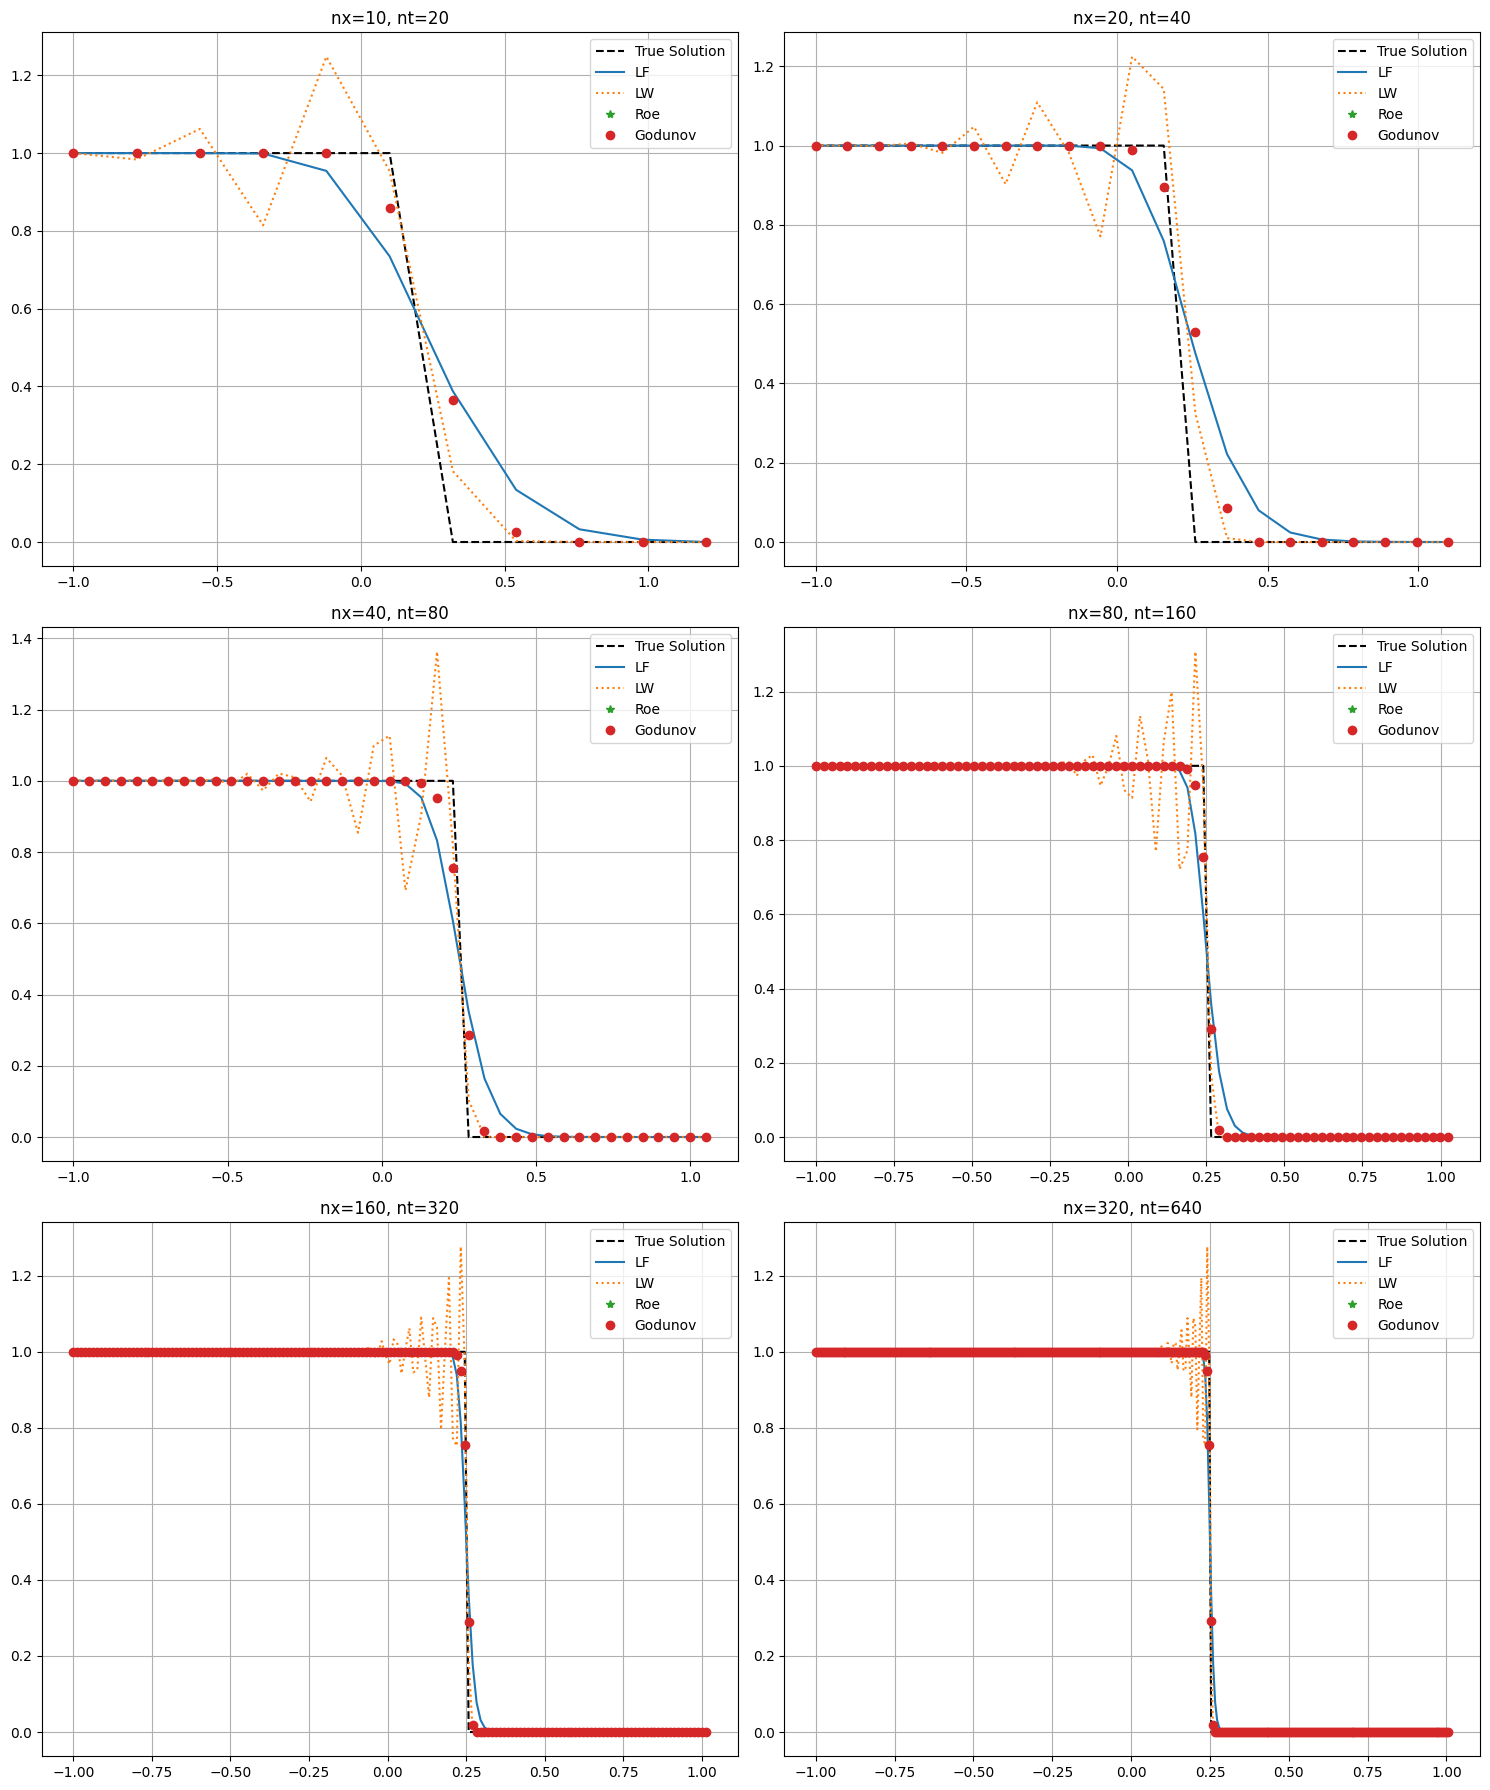

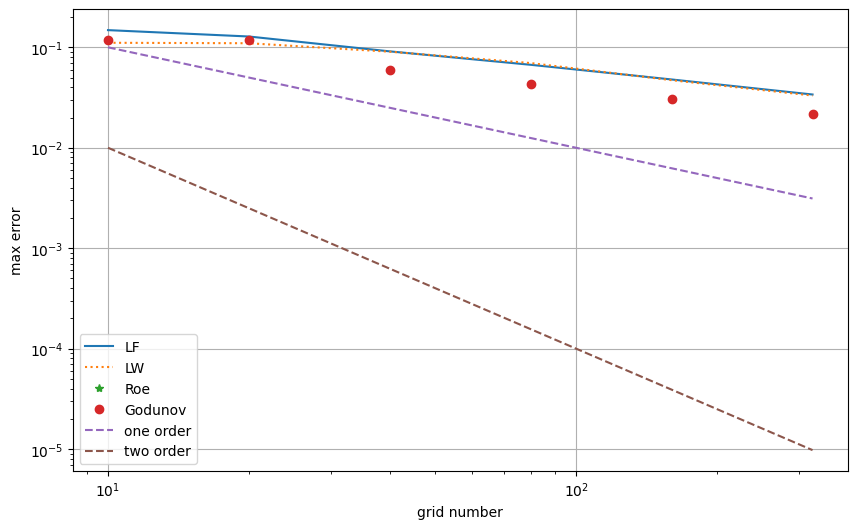

In [23]:
u_0 = lambda x: np.where(x<0.0, 1.0, 0.0)
u_true = lambda x, t: np.where(x<t/2, 1.0, 0.0)
Conservation_burgers(u_0, 0.5, -1, 1, boundary=None, exact_solution=u_true)

/tmp/ipykernel_991/264723541.py:2: RuntimeWarning: overflow encountered in square
  f = lambda u: u**2/2
/tmp/ipykernel_991/33153478.py:10: RuntimeWarning: overflow encountered in multiply
  f_r = (f(un[1:-1])+f(un[2:])-lam*diff_f((un[1:-1]+un[2:])/2)*(un[2:]-un[1:-1]))/2
/tmp/ipykernel_991/33153478.py:10: RuntimeWarning: invalid value encountered in subtract
  f_r = (f(un[1:-1])+f(un[2:])-lam*diff_f((un[1:-1]+un[2:])/2)*(un[2:]-un[1:-1]))/2
/tmp/ipykernel_991/33153478.py:11: RuntimeWarning: overflow encountered in multiply
  f_l = (f(un[1:-1])+f(un[:-2])-lam*diff_f((un[1:-1]+un[:-2])/2)*(un[1:-1]-un[:-2]))/2
/tmp/ipykernel_991/33153478.py:11: RuntimeWarning: invalid value encountered in subtract
  f_l = (f(un[1:-1])+f(un[:-2])-lam*diff_f((un[1:-1]+un[:-2])/2)*(un[1:-1]-un[:-2]))/2
/tmp/ipykernel_991/2744316819.py:13: RuntimeWarning: invalid value encountered in subtract
  result[1:-1] = un[1:-1] - dt/dx*(f_r - f_l)


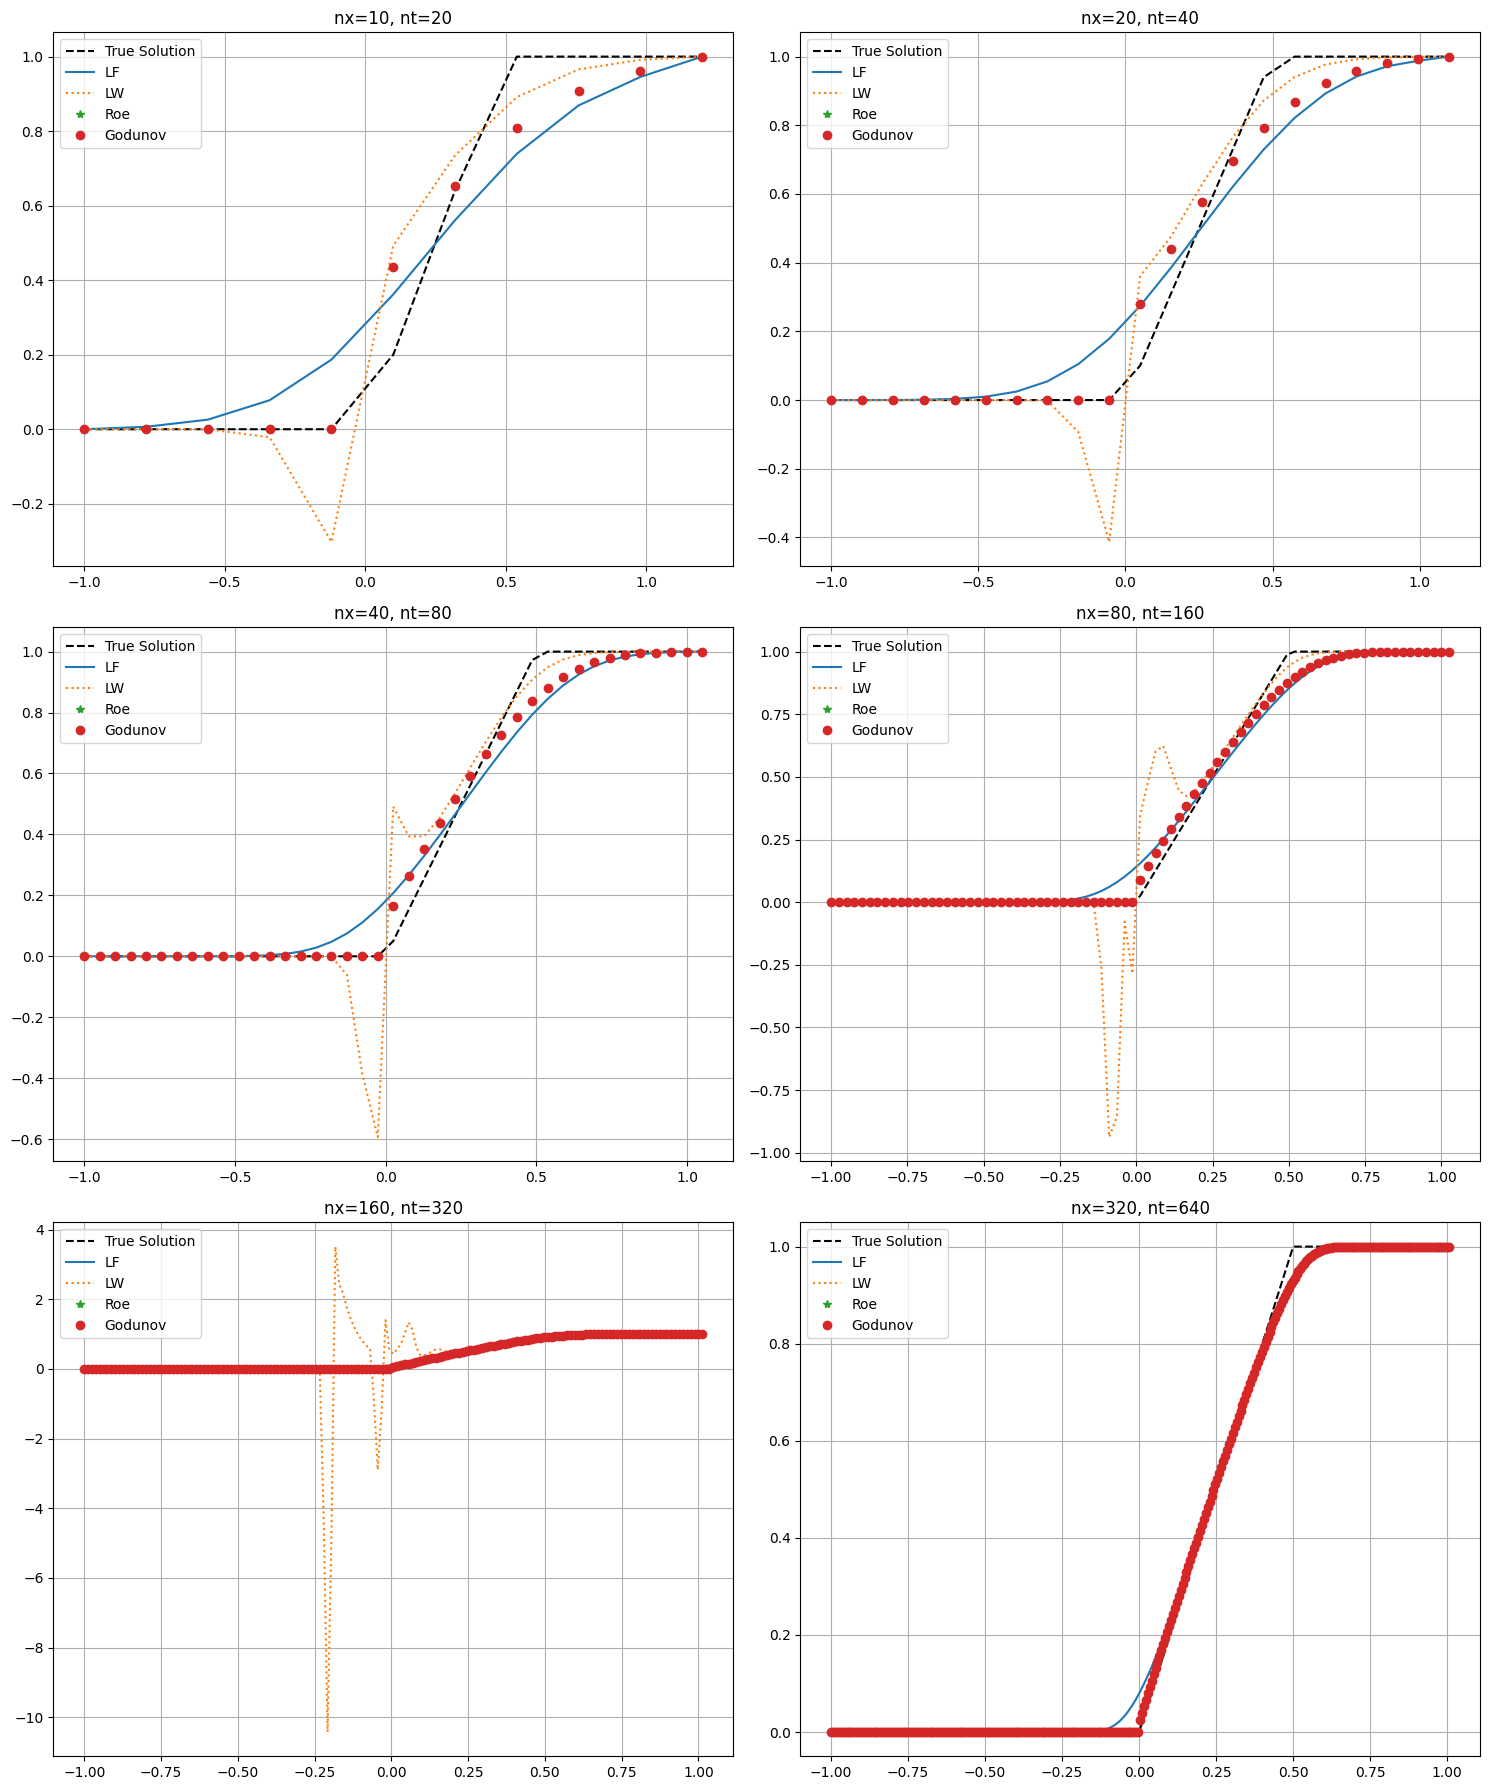

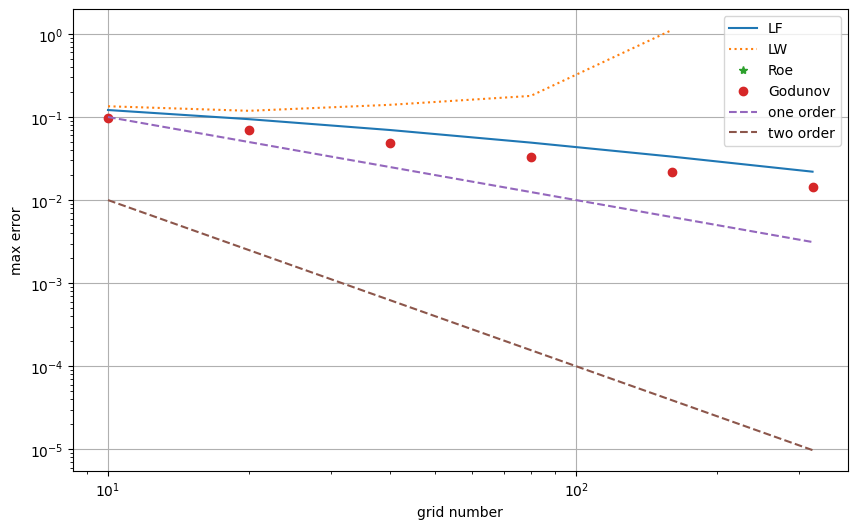

In [25]:
u_0 = lambda x: np.where(x<0.0, 0.0, 1.0)
u_true = lambda x, t: np.where(x<0.0, 0.0, np.where(x<t, x/t, 1.0))
Conservation_burgers(u_0, 0.5, -1, 1, boundary=None, exact_solution=u_true)

使用PINN求解上述非线性方程

Epoch 0, Loss: 4.77746e-01
Epoch 500, Loss: 2.50539e-02
Epoch 1000, Loss: 6.21655e-03
Epoch 1500, Loss: 3.71950e-03
Epoch 2000, Loss: 2.70638e-03
Epoch 2500, Loss: 2.13302e-03
Epoch 3000, Loss: 1.82882e-03
Epoch 3500, Loss: 1.66284e-03
Epoch 4000, Loss: 1.66573e-03
Epoch 4500, Loss: 1.45676e-03
Epoch 5000, Loss: 1.15034e-03
Epoch 5500, Loss: 1.07607e-03
Epoch 6000, Loss: 1.12938e-03
Epoch 6500, Loss: 1.04427e-03
Epoch 7000, Loss: 1.31421e-03
Epoch 7500, Loss: 9.30730e-04
Epoch 8000, Loss: 8.57631e-04
Epoch 8500, Loss: 7.77391e-04
Epoch 9000, Loss: 7.09860e-04
Epoch 9500, Loss: 6.71224e-04


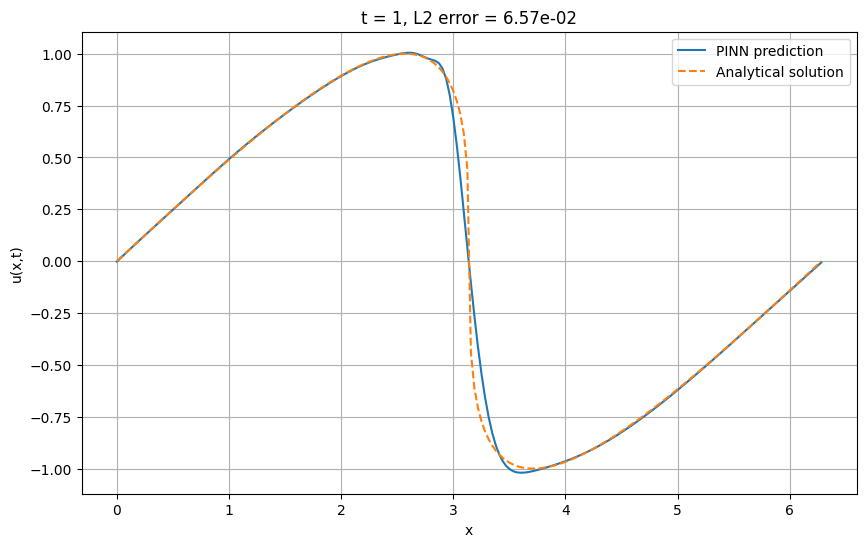

(PINN(
   (net): Sequential(
     (0): Linear(in_features=2, out_features=64, bias=True)
     (1): SiLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): SiLU()
     (4): Linear(in_features=64, out_features=64, bias=True)
     (5): SiLU()
     (6): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 np.float64(0.06572383763922682))

In [20]:
l = 0
r = 2*torch.pi
T = 1
u0_func = lambda x: torch.sin(x)
solve_pde_with_pinn(u0_func, exact_solution_burgers, l, r, T, f=lambda u: u**2/2, epochs=10000)

Epoch 0, Loss: 1.29477e+00
Epoch 500, Loss: 6.45882e-02
Epoch 1000, Loss: 3.50659e-02
Epoch 1500, Loss: 2.97984e-02
Epoch 2000, Loss: 2.68604e-02
Epoch 2500, Loss: 2.51343e-02
Epoch 3000, Loss: 2.39213e-02
Epoch 3500, Loss: 2.30259e-02
Epoch 4000, Loss: 2.26588e-02
Epoch 4500, Loss: 2.24457e-02
Epoch 5000, Loss: 2.19807e-02
Epoch 5500, Loss: 2.19170e-02
Epoch 6000, Loss: 2.18669e-02
Epoch 6500, Loss: 2.14591e-02
Epoch 7000, Loss: 2.13831e-02
Epoch 7500, Loss: 2.11218e-02
Epoch 8000, Loss: 2.11777e-02
Epoch 8500, Loss: 2.11913e-02
Epoch 9000, Loss: 2.10600e-02
Epoch 9500, Loss: 2.10758e-02


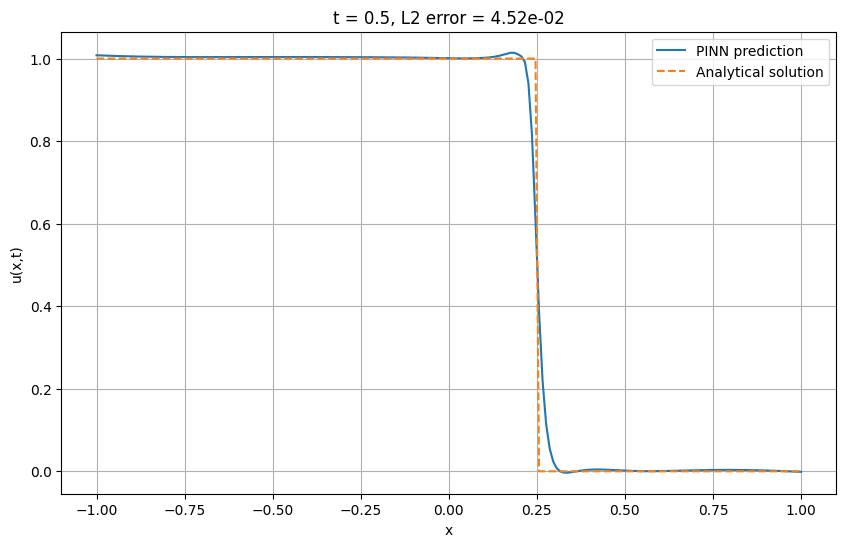

(PINN(
   (net): Sequential(
     (0): Linear(in_features=2, out_features=64, bias=True)
     (1): SiLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): SiLU()
     (4): Linear(in_features=64, out_features=64, bias=True)
     (5): SiLU()
     (6): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 np.float64(0.04519096672858777))

In [27]:
l = -1
r = 1
T = 0.5
u0_func = lambda x: torch.where(x<0.0, 1.0, 0.0)
u_true = lambda x, t: np.where(x<t/2, 1.0, 0.0)
solve_pde_with_pinn(u0_func, u_true, l, r, T, f=lambda u: u**2/2, epochs=10000, boundary='Dirichlet', b_l=1.0, b_r=0.0)

Epoch 0, Loss: 1.51039e+00
Epoch 500, Loss: 5.68358e-02
Epoch 1000, Loss: 1.83258e-02
Epoch 1500, Loss: 9.61129e-03
Epoch 2000, Loss: 6.64574e-03
Epoch 2500, Loss: 5.11147e-03
Epoch 3000, Loss: 4.19144e-03
Epoch 3500, Loss: 3.57613e-03
Epoch 4000, Loss: 2.92924e-03
Epoch 4500, Loss: 2.74577e-03
Epoch 5000, Loss: 2.38875e-03
Epoch 5500, Loss: 2.19999e-03
Epoch 6000, Loss: 1.89061e-03
Epoch 6500, Loss: 1.49354e-03
Epoch 7000, Loss: 1.43610e-03
Epoch 7500, Loss: 1.30794e-03
Epoch 8000, Loss: 1.21501e-03
Epoch 8500, Loss: 1.06166e-03
Epoch 9000, Loss: 9.60205e-04
Epoch 9500, Loss: 1.02688e-03


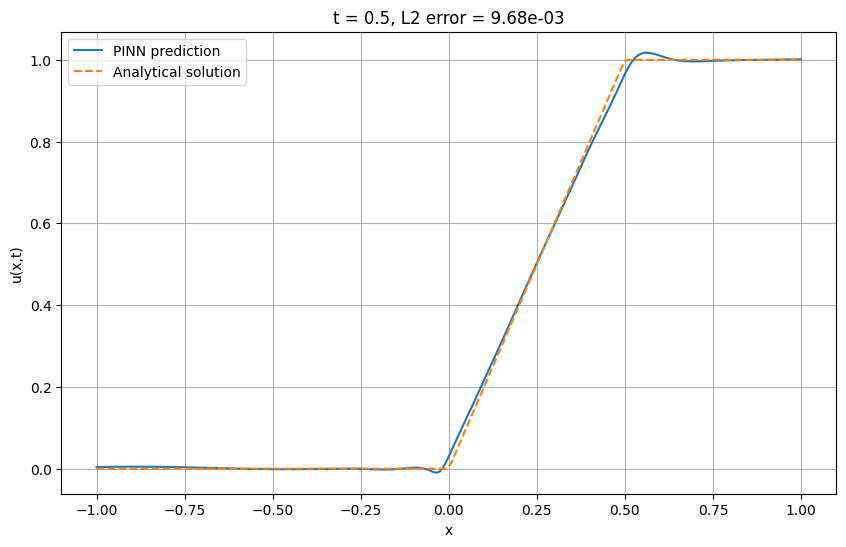

(PINN(
   (net): Sequential(
     (0): Linear(in_features=2, out_features=64, bias=True)
     (1): SiLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): SiLU()
     (4): Linear(in_features=64, out_features=64, bias=True)
     (5): SiLU()
     (6): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 np.float32(0.0096776625))

In [29]:
l = -1
r = 1
T = 0.5
u0_func = lambda x: torch.where(x<0.0, 0.0, 1.0)
u_true = lambda x, t: np.where(x<0.0, 0.0, np.where(x<t, x/t, 1.0))
solve_pde_with_pinn(u0_func, u_true, l, r, T, f=lambda u: u**2/2, epochs=10000, boundary='Dirichlet', b_l=0.0, b_r=1.0)

/root/miniconda3/envs/torch/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 2.44629e-01
Epoch 500, Loss: -1.54358e+00
Epoch 1000, Loss: -3.05310e+00
Epoch 1500, Loss: -4.54852e+00
Epoch 2000, Loss: -6.05552e+00
Epoch 2500, Loss: -7.54889e+00
Epoch 3000, Loss: -9.03205e+00
Epoch 3500, Loss: -1.04878e+01
Epoch 4000, Loss: -1.18800e+01
Epoch 4500, Loss: -1.31452e+01


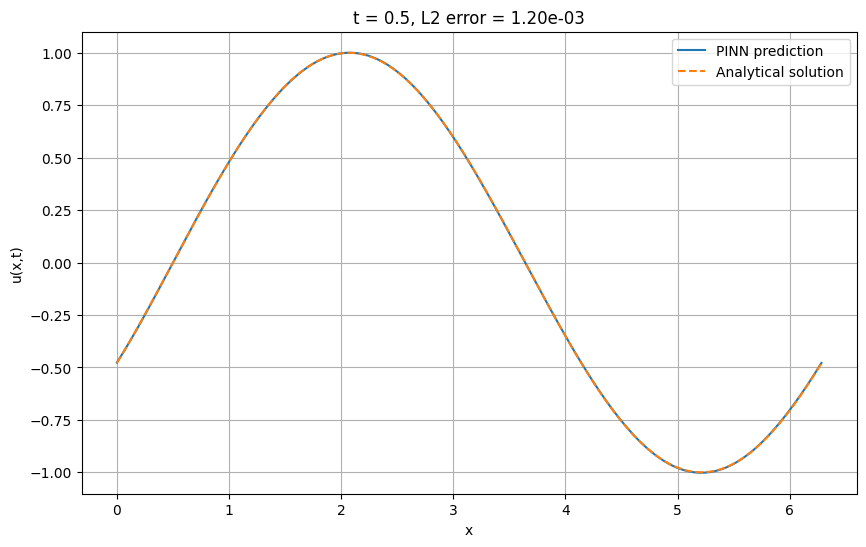

(PINN(
   (net): Sequential(
     (0): Linear(in_features=2, out_features=64, bias=True)
     (1): SiLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): SiLU()
     (4): Linear(in_features=64, out_features=64, bias=True)
     (5): SiLU()
     (6): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 np.float32(0.0012019756))

Epoch 0, Loss: 6.00159e-01
Epoch 500, Loss: -1.50968e+00
Epoch 1000, Loss: -3.04427e+00
Epoch 1500, Loss: -4.56019e+00
Epoch 2000, Loss: -6.07423e+00
Epoch 2500, Loss: -7.58928e+00
Epoch 3000, Loss: -9.09253e+00
Epoch 3500, Loss: -1.05817e+01
Epoch 4000, Loss: -1.20463e+01
Epoch 4500, Loss: -1.31360e+01
Epoch 5000, Loss: -1.47966e+01
Epoch 5500, Loss: -1.60106e+01
Epoch 6000, Loss: -1.69823e+01
Epoch 6500, Loss: -1.76539e+01
Epoch 7000, Loss: -1.79436e+01
Epoch 7500, Loss: -1.73719e+01
Epoch 8000, Loss: -1.87071e+01
Epoch 8500, Loss: -1.93103e+01
Epoch 9000, Loss: -1.94622e+01
Epoch 9500, Loss: -1.96535e+01


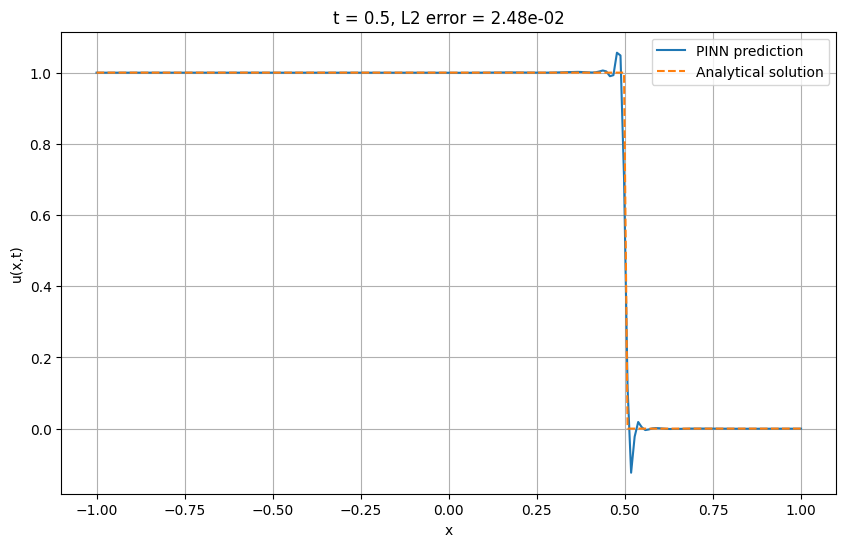

(PINN(
   (net): Sequential(
     (0): Linear(in_features=2, out_features=64, bias=True)
     (1): SiLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): SiLU()
     (4): Linear(in_features=64, out_features=64, bias=True)
     (5): SiLU()
     (6): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 np.float64(0.02481370792201277))

In [28]:
l = -1
r = 1
T = 0.5
u0_func = lambda x: torch.where(x<0.0, 1.0, 0.0)
u_true_func = lambda x, t: np.where(x<t, 1.0, 0.0)
solve_pde_with_lbpinn(u0_func, u_true_func, l, r, T, f=lambda u: u, epochs=10000, boundary='Dirichlet', b_l=1.0, b_r=0.0)

Epoch 0, Loss: 2.54790e-01
Epoch 500, Loss: -1.51567e+00
Epoch 1000, Loss: -3.04244e+00
Epoch 1500, Loss: -4.54199e+00
Epoch 2000, Loss: -6.01012e+00
Epoch 2500, Loss: -7.40707e+00
Epoch 3000, Loss: -8.26333e+00
Epoch 3500, Loss: -9.79057e+00
Epoch 4000, Loss: -1.04717e+01
Epoch 4500, Loss: -1.12090e+01
Epoch 5000, Loss: -1.16971e+01
Epoch 5500, Loss: -1.22045e+01
Epoch 6000, Loss: -1.18480e+01
Epoch 6500, Loss: -1.11255e+01
Epoch 7000, Loss: -1.32418e+01
Epoch 7500, Loss: -1.34896e+01
Epoch 8000, Loss: -1.26503e+01
Epoch 8500, Loss: -1.36782e+01
Epoch 9000, Loss: -1.37660e+01
Epoch 9500, Loss: -1.38433e+01
Epoch 10000, Loss: -1.36545e+01
Epoch 10500, Loss: -1.39942e+01
Epoch 11000, Loss: -1.40587e+01
Epoch 11500, Loss: -3.74442e+00
Epoch 12000, Loss: -1.40422e+01
Epoch 12500, Loss: -1.43219e+01
Epoch 13000, Loss: -1.43211e+01
Epoch 13500, Loss: -1.42384e+01
Epoch 14000, Loss: -1.43106e+01
Epoch 14500, Loss: -1.44231e+01
Epoch 15000, Loss: -1.44343e+01
Epoch 15500, Loss: -1.44931e+01
E

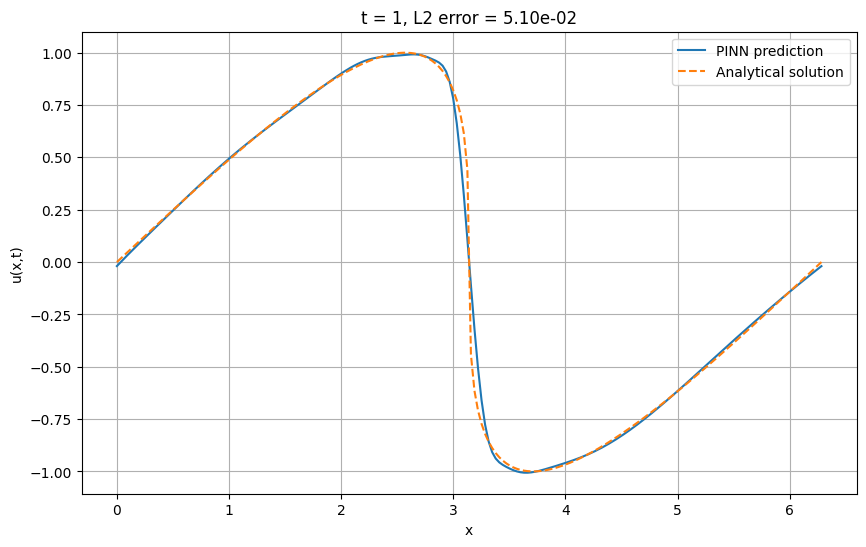

(PINN(
   (net): Sequential(
     (0): Linear(in_features=2, out_features=64, bias=True)
     (1): SiLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): SiLU()
     (4): Linear(in_features=64, out_features=64, bias=True)
     (5): SiLU()
     (6): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 np.float64(0.0509982173746603))

In [33]:
l = 0
r = 2*torch.pi
T = 1
u0_func = lambda x: torch.sin(x)
solve_pde_with_lbpinn(u0_func, exact_solution_burgers, l, r, T, f=lambda u: u**2/2, epochs=20000)

Epoch 0, Loss: 8.82812e-01
Epoch 500, Loss: -1.43788e+00
Epoch 1000, Loss: -2.91282e+00
Epoch 1500, Loss: -4.23231e+00
Epoch 2000, Loss: -5.34907e+00
Epoch 2500, Loss: -6.33053e+00
Epoch 3000, Loss: -7.29785e+00
Epoch 3500, Loss: -8.07055e+00
Epoch 4000, Loss: -9.02527e+00
Epoch 4500, Loss: -1.00772e+01
Epoch 5000, Loss: -1.08732e+01
Epoch 5500, Loss: -1.13211e+01
Epoch 6000, Loss: -1.20320e+01
Epoch 6500, Loss: -1.24277e+01
Epoch 7000, Loss: -1.27271e+01
Epoch 7500, Loss: -1.29709e+01
Epoch 8000, Loss: -1.31408e+01
Epoch 8500, Loss: -1.32782e+01
Epoch 9000, Loss: -6.80266e+00
Epoch 9500, Loss: -1.34726e+01
Epoch 10000, Loss: -1.07074e+01
Epoch 10500, Loss: -1.37890e+01
Epoch 11000, Loss: -1.38565e+01
Epoch 11500, Loss: -1.39537e+01
Epoch 12000, Loss: -1.39387e+01
Epoch 12500, Loss: -1.40955e+01
Epoch 13000, Loss: -1.40562e+01
Epoch 13500, Loss: -1.26695e+01
Epoch 14000, Loss: -1.41055e+01
Epoch 14500, Loss: -1.42601e+01
Epoch 15000, Loss: -1.43365e+01
Epoch 15500, Loss: -1.43793e+01
E

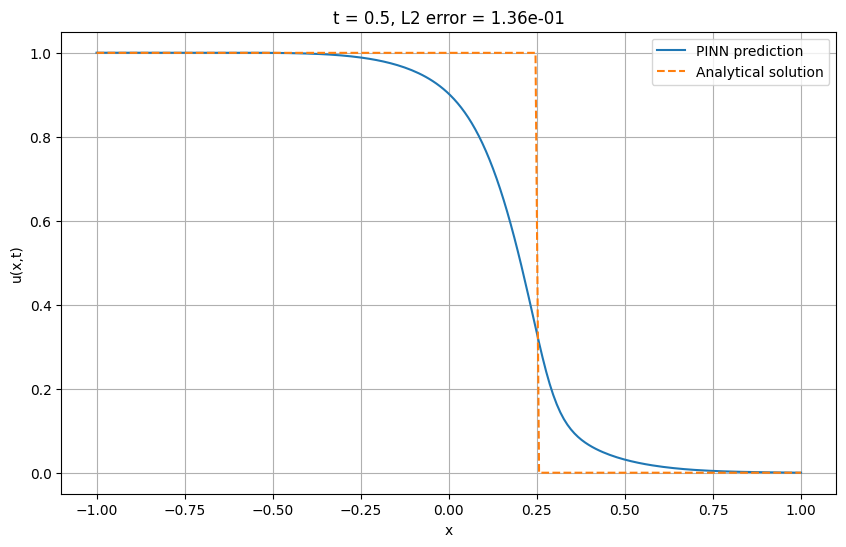

(PINN(
   (net): Sequential(
     (0): Linear(in_features=2, out_features=64, bias=True)
     (1): SiLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): SiLU()
     (4): Linear(in_features=64, out_features=64, bias=True)
     (5): SiLU()
     (6): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 np.float64(0.13581253618924477))

In [34]:
l = -1
r = 1
T = 0.5
u0_func = lambda x: torch.where(x<0.0, 1.0, 0.0)
u_true = lambda x, t: np.where(x<t/2, 1.0, 0.0)
solve_pde_with_lbpinn(u0_func, u_true, l, r, T, f=lambda u: u**2/2, epochs=20000, boundary='Dirichlet', b_l=1.0, b_r=0.0)